# DATA1050 Project

## Table of Contents

**1. [Introduction](#intro)**
    
**2. [Preprocessing](#prep)**
>**2.1 | [Data/Module Imports](#datastart)**  
>**2.2 | [Quick EDA of Entire Dataset](#quickeda)**  
>**2.3 | [Feature Engineering](#FE)**  
>**2.4 | [Data Splitting](#DS)**   
>**2.5 | [Data Encoding](#DE)**   

**3. [Feature Selection: Correlation/Correlation Matrix](#correlation)**
>**3.1 | [Linear Correlation: F Test](#ftest)**  
>**3.2 | [Non-Linear Correlation: Mutual Information](#mutual)**  
>**3.3 | [Selecting the 'Best' features for both City and Resort Hotels ](#hotel)**  

**4. [EDA: Individual Features (chosen based on Correlation)](#eda)**
>**4.1 | [adr (Target)](#adr)**  
>**4.2 | [market_segment](#ms)**   
>**4.3 | [reserved_room_type](#rrt)**  
>**4.4 | [assigned_room_type](#ast)**   
>**4.5 | [children](#children)**   
>**4.6 | [agent](#agent)**     
>**4.7 | [lead_time](#lead)**     
>**4.8 | [stays_in_week_nights](#week)**   
>**4.9 | [stays_in_weekend_nights](#weekend)**   
>**4.10 | [deposit_type](#deposit)**    
>**4.11 | [country](#country)**   
>**4.12 | [days_in_waiting_list](#waiting)**   
>**4.13 | [meal](#meal)**   


**5. [EDA: Multivariate EDA](#multieda)**

**6. [Modeling](#modeling)**
>**6.1 | [Linear Regression w/ L1 Regularization (Lasso)](#lasso)**   
>**6.2 | [Linear Regression w/ L2 Regularization (Ridge)](#ridge)**   
>**6.3 | [Linear Regression w/ L3 Regularization (Elasticnet)](#el)**    
>**6.4 | [Support Vector Regression](#svr)**     
>**6.5 | [Random Forest Regression](#rfr)**    
>**6.6 | [XGBoost Regression](#xgb)**

**7. [Performance](#performance)**
>**7.1 | [Best Scores](#best)**   
>**7.2 | [General Performance of Test Scores vs Baseline](#testvsbase)**    
>**7.3 | [Global Importance Metrics](#global)**

---

<a id = 'intro'><a/>

## 1.  Introduction

**Mission Statement:** 

The hotel industry, approximately worth 822 Billion (MaximizeMarkeResearch), is a mercurial environment stimulated by our need to explore every corner of the globe. While the industry has generally been booming with the increase in the younger generations increased wealth and need to travel on top of technological advances to make check-ins and booking easier, recent events such as COVID, has shown the industry what the financial impact can be if travel were to stop all together. As a result, it becomes incredibely important for hotels/resorts to understand their financial health as well as understand what factors may contribute to their bottom line.


Source:https://www.maximizemarketresearch.com/market-report/hotels-market/47478/#:~:text=Hotels%20Market%20was%20valued%20at%20USD%20822.86%20Billion,return%20for%20money%20-%20on%20a%20short-term%20basis.

---

<a id = 'prep'><a/>

## 2. Preprocessing

###  *2.1  &ensp; Data/Module Imports*

In [319]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.impute import SimpleImputer
import calendar
from sklearn.feature_selection import SelectKBest
import plotly.express as px
import kaleido
import math
import warnings
import pickle


In [2]:
#get rid of future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [260]:
#read in dataset
df = pd.read_csv('data\hotel_bookings.csv')
df_xgb = pd.read_csv('data\hotel_bookings.csv')


**Note**: Not sure why duplicates exist as the data was taken from the PMS system of two hotels. However, the likelihood that the information from two different reservations are all consistent is a bit wierd and unlikely so treating them as duplicates.

### 2.2 &ensp; Quick EDA of Entire Dataset

In [4]:
#shape of dataframe
print('row:', df.shape[0], '|' , 'column:', df.shape[1])

row: 87396 | column: 32


In [5]:
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0                7/1/2015  
1                7/1/2015  
2                7/2/2015  
3                7/2/2015  
4                7/3/2015  

[5 rows x 32 columns]

In [159]:
print(np.unique(df['reserved_room_type']))
print(np.unique(df['assigned_room_type']))             


['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'L' 'P']
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'P']


In [6]:
#dtypes of columnms
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [7]:
nan = pd.DataFrame({'Missing Value' : df.isnull().sum(), '%Missing Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
nan

Missing Value  %Missing Values
hotel                                       0         0.000000
is_canceled                                 0         0.000000
lead_time                                   0         0.000000
arrival_date_year                           0         0.000000
arrival_date_month                          0         0.000000
arrival_date_week_number                    0         0.000000
arrival_date_day_of_month                   0         0.000000
stays_in_weekend_nights                     0         0.000000
stays_in_week_nights                        0         0.000000
adults                                      0         0.000000
children                                    4         0.004577
babies                                      0         0.000000
meal                                        0         0.000000
country                                   452         0.517186
market_segment                              0         0.000000
distribution_channel                        0         0.000000
is_repeated_guest                           0         0.000000
previous_cancellations                      0         0.000000
previous_bookings_not_canceled              0         0.000000
reserved_room_type                          0         0.000000
assigned_room_type                          0         0.000000
booking_changes                             0         0.000000
deposit_type                                0         0.000000
agent                                   12193        13.951439
company                                 82137        93.982562
days_in_waiting_list                        0         0.000000
customer_type                               0         0.000000
adr                                         0         0.000000
required_car_parking_spaces                 0         0.000000
total_of_special_requests                   0         0.000000
reservation_status                          0         0.000000
reservation_status_date                     0         0.000000

### 2.3 &ensp; Feature Engineering

> #### 2.3.1  &ensp; Creating New Feature: Season

In [8]:
##creating a new feature: Season to take into account the month

#function
def monToSeason(Mon):
    return {
            'January': 'Winter',
            'February': 'Winter',
            'March': 'Spring',
            'April': 'Spring',
            'May': 'Spring',
            'June': 'Summer',
            'July': 'Summer',
            'August': 'Summer',
            'September': 'Fall', 
            'October': 'Fall',
            'November': 'Fall',
            'December': 'Winter'
    }[Mon]

#creating arrival month_num column
df['Season'] =  [monToSeason(date) for date in df['arrival_date_month']]
df_xgb['Season'] =  [monToSeason(date) for date in df['arrival_date_month']]

> #### 2.3.2 &ensp; Adding new company ID to represent reservations that weren't booked by companies

**Reason** : Although over 94% of values are missing, it is better to categorize the 94% with the same ID without dropping the column

In [9]:
#filling in missing values with ID: 0 to represent bookings not made by companies
df['company'].fillna(0, inplace = True) #0 is equal to no agent

In [10]:
#checking
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'Season'],
      dtype='object')

> #### 2.3.3 &ensp; Deleting rows with missing values for 'country'

**Reason** : 488 rows or 0.5% of the total number of rows have missing values. I deem it small enough that it won't have a significant impact on my analysis

In [11]:
#dropping rows with missing values for column, 'country'
df  = df.dropna( how='any',subset=['country'])

> #### 2.3.4 &ensp; Filling in missing values for columns, "Agent", with 'No Agent'

**Reason** : Rather than dropping the rows or column, I propose we fill in missing values with 'No Agent' to signify that the hotel reservation was made by the individual rather than by a booking. company. This may prove insightful as I would like to preserve as many features as possible

In [12]:
df['agent'].fillna(0, inplace = True) #0 is equal to no agent

> #### 2.3.5 &ensp; Extracting Month from Reservation Status Date


**Reason** : Similar to 'Arrival_Date_Month', I would like to track the monthly variation in reservation status change. Tracking by years seems inadequate as we only have 3 years of data

In [13]:
##checking to see if reservation date and arrival month are basically the same

#creating 'reservation_status_date' as a datetime object
df['reservation_status_date'] = df['reservation_status_date'].apply(pd.to_datetime)


#create new columns: reservation_status_month, reservation_status_year, reservation_status_day

df['res_status_month_num'] = df['reservation_status_date'].dt.month
df['res_status_month'] = df['res_status_month_num'].apply(lambda x: calendar.month_name[x])
df['res_status_year'] = df['reservation_status_date'].dt.year.astype('str')

#drop reservation status
df = df.drop ('reservation_status_date',axis=1)




#do the same for xgb data
df_xgb['reservation_status_date'] = df_xgb['reservation_status_date'].apply(pd.to_datetime)


#create new columns: reservation_status_month, reservation_status_year, reservation_status_day

df_xgb['res_status_month_num'] = df_xgb['reservation_status_date'].dt.month
df_xgb['res_status_month'] = df_xgb['res_status_month_num'].apply(lambda x: calendar.month_name[x])
df_xgb['res_status_year'] = df_xgb['reservation_status_date'].dt.year.astype('str')


df_xgb = df_xgb.drop ('reservation_status_date',axis=1)

> #### 2.3.6 &ensp; Transforming Reservation Month using sinusoidal function


**Reason** : Month is an ordinal feature; however, ordinality is under the presumption of a 1 dimensional relationship among the features. However, the month resets to the beginning of the ordinal list of months. In otherwords, using an ordinal encoder will not take into account the neighborhood relationship between January and December, thus using a sinusoidal function to demonstrate that relationships should account for this missing relationship.

In [14]:
#period of sin(x)
period = 2 * math.pi
#calculating the cardinality of month 
cardinality = len(np.unique(df['res_status_month']))

#numerical transformation using sin(x)
df['Res_Month_Sin'] = df['res_status_month_num'].apply(lambda row: math.sin((period/cardinality)*row))

#do the same for xgb data
df_xgb['Res_Month_Sin'] =df_xgb['res_status_month_num'].apply(lambda row: math.sin((period/cardinality)*row))

### 2.4 &ensp; Splitting Data

> #### 2.4.1 &ensp; Production Data

In [15]:
#splitting data into resort vs city

#no missing data
df_city = df[df['hotel'] == 'City Hotel']
df_resort = df[df['hotel'] == 'Resort Hotel']

#missing data
df_xgb_city = df_xgb[df_xgb['hotel'] == 'City Hotel']
df_xgb_resort = df_xgb[df_xgb['hotel'] == 'Resort Hotel']

#getting rid of hotel columns

#no missing data
df_city = df_city.drop('hotel', axis = 1)
df_resort = df_resort.drop('hotel', axis = 1)

#missing data
df_xgb_city =df_xgb_city.drop('hotel', axis = 1)
df_xgb_resort  = df_xgb_resort.drop('hotel', axis = 1)

In [16]:
#creating simple train test split function with random state parameter (will be useful later for modeling)

def tts_rs(X,y,train_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size, random_state = random_state)
    return X_train, X_test, y_train, y_test

In [17]:
##City Hotel Split

##No missing data
#split features and target
city_y = df_city['adr']
city_X = df_city.loc[:,df_city.columns != 'adr']

#creating split
c_X_train, c_X_test, c_y_train, c_y_test = tts_rs(city_X, city_y, 0.8,13)


#missing data
#split features and target
xgb_city_y= df_xgb_city['adr']
xgb_city_X = df_xgb_city.loc[:,df_xgb_city.columns != 'adr']

#creating split
c_X_train_xgb, c_X_test_xgb, c_y_train_xgb, c_y_test_xgb = tts_rs(xgb_city_X,xgb_city_y, 0.8,13)




In [18]:
#Resort Hotel Split

##missing data
#split features and target
resort_y = df_resort['adr']
resort_X = df_resort.loc[:,df_resort.columns != 'adr']

#creating split
r_X_train, r_X_test, r_y_train, r_y_test = train_test_split(resort_X, resort_y, train_size = 0.8)


#missing data
#split features and target
xgb_resort_y = df_xgb_resort['adr']
xgb_resort_X = df_xgb_resort.loc[:,df_xgb_resort.columns != 'adr']

#creating split
r_X_train_xgb, r_X_test_xgb, r_y_train_xgb, r_y_test_xgb = tts_rs(xgb_resort_X,xgb_resort_y, 0.8,13)

In [19]:
#step 1
print('Step 1. Split into 2 datasets:')
print("df_city = df[df['hotel'] == 'City Hotel']")
print("df_resort = df[df['hotel'] == 'Resort Hotel']")
print('\n')
#step 2
print("# of Rows:")
print("len(City Hotel DF):",len(df_city))
print("len(resort Hotel DF):",len(df_resort))
print('\n')
#step 3
print('Step 2. Split 2 datasets so each has test, val, and test set:')
print('City Hotel: c_X_train:', len(c_X_train), '\t   c_X_test:', len(c_X_test))
print('Resort Hotel: r_X_train:', len(r_X_train), '\t  r_X_test:', len(r_X_test))

Step 1. Split into 2 datasets:
df_city = df[df['hotel'] == 'City Hotel']
df_resort = df[df['hotel'] == 'Resort Hotel']


# of Rows:
len(City Hotel DF): 53422
len(resort Hotel DF): 33522


Step 2. Split 2 datasets so each has test, val, and test set:
City Hotel: c_X_train: 42737 	   c_X_test: 10685
Resort Hotel: r_X_train: 26817 	  r_X_test: 6705


> #### 2.4.2 &ensp; Sample Data (For Model testing)

In [20]:
#creating sample data for city hotel data from original

#non-missing sample
c_sample = df_city.sample(n=5000)

city_y = c_sample['adr']
city_X = c_sample.loc[:,df_city.columns != 'adr']


#missing sample

c_sample_xgb = df_xgb_city.sample(n=5000)

city_Xgb_y = c_sample_xgb['adr']
city_Xgb_x = c_sample_xgb.loc[:, df_city.columns != 'adr']



In [21]:
#creating sample data for resort hotel data from original\

#non-missing sample
r_sample = df_resort.sample(n=6000)

resort_y = r_sample['adr']
resort_X = r_sample.loc[:,df_city.columns != 'adr']


#missing sample

r_sample_xgb = df_xgb_resort.sample(n=6000)

resort_Xgb_y = r_sample_xgb['adr']
resort_Xgb_x = r_sample_xgb.loc[:, df_city.columns != 'adr']


### 2.5 &ensp; Preprocessing

> #### 2.5.1 For Non-XGB Models

In [223]:
#collect different features

cat_ftrs = ['is_canceled','meal','country','market_segment','distribution_channel','is_repeated_guest','reserved_room_type','assigned_room_type', 'deposit_type', \
            'agent','customer_type','reservation_status','Season','company']



ordinal_ftrs = ['arrival_date_month','res_status_month']


ordinal_cats = [['January','February','March','April','May','June','July','August','September','October','November','December'],\
               ['January','February','March','April','May','June','July','August','September','October','November','December']]

            
num_ftrs = ['lead_time','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies', 'previous_cancellations','previous_bookings_not_canceled', \
            'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests','Res_Month_Sin','res_status_month_num','res_status_year','arrival_date_year']

In [224]:
##create pipelines and transformers to encode the column data

#OneHotEncoder
cat_transformer = Pipeline(steps =[
    ('onehot',OneHotEncoder(sparse = False, handle_unknown='ignore'))])
                           
#StandardScaler
num_transformer = Pipeline(steps = [
     ('imputer', SimpleImputer(strategy='most_frequent')), #to address the 4 missing values in children
    ('stnd', StandardScaler())])


#OrdinalEncoder
ord_transformer = Pipeline(steps = [
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
               

preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_transformer,num_ftrs),
        ('onehot',cat_transformer, cat_ftrs),
    ('ord', ord_transformer, ordinal_ftrs)])



In [228]:

##non-missing data

#fit_transform the training sets FOR CITY HOTEL
c_X_prep = preprocessor.fit_transform(c_X_train)

#getting feature names after the fit
c_feature_name = preprocessor.get_feature_names_out()

#converting numpy array in df with feature names FOR CITY HOTEL
c_df_train = pd.DataFrame(data = c_X_prep, columns = c_feature_name)
print("City Hotel Preprocessed Training Data Shape:" , c_df_train.shape)

#transform testing set
c_X_test_prep = preprocessor.transform(c_X_test)
c_df_test = pd.DataFrame(data = c_X_test, columns = c_feature_name)
print("City Hotel Preprocessed Test Data Shape:" , c_df_test.shape)

City Hotel Preprocessed Training Data Shape: (42737, 635)
City Hotel Preprocessed Test Data Shape: (10685, 635)


In [227]:
##non-missing

#fit_transform the training sets FOR RESORT HOTEL
r_X_prep = preprocessor.fit_transform(r_X_train)

#getting feature names after the fit
r_feature_name = preprocessor.get_feature_names_out()


#converting numpy array in df with feature names FOR CITY HOTEL
r_df_train = pd.DataFrame(data = r_X_prep, columns = r_feature_name)
print("Resort Hotel Preprocessed Training Data Shape:" , r_df_train.shape)

#transform testing set
r_X_test_prep = preprocessor.transform(r_X_test)
r_df_test = pd.DataFrame(data = r_X_test_prep, columns = r_feature_name)
print("Resort Hotel Preprocessed Test Data Shape:" , r_df_test.shape)


Resort Hotel Preprocessed Training Data Shape: (26817, 582)
Resort Hotel Preprocessed Test Data Shape: (6705, 582)


In [26]:
print('Shapes of all sets post-preprocessing:')
print('City Hotel:   c_X_train:', c_df_train.shape, '\t c_X_test:', c_df_test.shape)
print('Resort Hotel: r_X_train:', r_df_train.shape, '\t \t r_X_test:', r_df_test.shape)

Shapes of all sets post-preprocessing:
City Hotel:   c_X_train: (42737, 635) 	 c_X_test: (10685, 635)
Resort Hotel: r_X_train: (26817, 582) 	 	 r_X_test: (6705, 582)


> #### 2.5.2 &ensp; For XGB Model

In [27]:
#collect different features

cat_ftrs = ['is_canceled','meal','country','market_segment','distribution_channel','is_repeated_guest','reserved_room_type','assigned_room_type', 'deposit_type', \
            'agent','customer_type','reservation_status','Season','company']



ordinal_ftrs = ['arrival_date_month','res_status_month']


ordinal_cats = [['January','February','March','April','May','June','July','August','September','October','November','December'],\
               ['January','February','March','April','May','June','July','August','September','October','November','December']]

            
num_ftrs = ['lead_time','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies', 'previous_cancellations','previous_bookings_not_canceled', \
            'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests','Res_Month_Sin','res_status_month_num','res_status_year','arrival_date_year']

In [28]:
##create pipelines and transformers to encode the column data

#OneHotEncoder
cat_transformer1 = Pipeline(steps =[
    ('onehot',OneHotEncoder(sparse = False, handle_unknown='ignore'))])
                           
#StandardScaler
num_transformer1 = Pipeline(steps = [
    ('stnd', StandardScaler())])


#OrdinalEncoder
ord_transformer1 = Pipeline(steps = [
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
               

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num',num_transformer1,num_ftrs),
        ('onehot',cat_transformer1, cat_ftrs),
    ('ord', ord_transformer1, ordinal_ftrs)])


In [235]:
#finding # of columns for preprocessed XGB data
c_X_prep_xgb = preprocessor_xgb.fit_transform(c_X_train_xgb)
print(c_X_prep_xgb.shape)
r_X_prep_xgb = preprocessor_xgb.fit_transform(r_X_train_xgb)
print(r_X_prep_xgb.shape)

(42742, 628)
(27174, 590)


---

## 3. &ensp; Feature Selection (for EDA)

<a id = 'ftest'><a/>

> ### 3.1 &ensp; Linear Correlation: F-Test

**Standard**: 5% Significance Level

In [29]:
##CITY HOTEL

#finding f_stats for city hotel
c_f_stats = f_regression(c_df_train, c_y_train)

#top 20 correlated features
data = list(zip(c_df_train.columns,c_f_stats[1]))
lin_df =pd.DataFrame(data, columns = ['features','p-values'])
lin_df = lin_df.sort_values(by='p-values', ascending = True).reset_index(drop =True)
c_sig_features = lin_df[lin_df['p-values'] <= 0.05]



In [30]:
#TESTING SELECTKBEST

fs = SelectKBest(score_func=f_regression, k=5)
"""
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
return X_train_fs, X_test_fs, fs
"""

#finding f_stats for city hotel and 5 best features
fs.fit(c_df_train, c_y_train)
x_train_test = fs.transform(c_df_train)
                            
x_train_names = fs.get_feature_names_out()

data = list(zip(x_train_names,x_train_test))
lin_df =pd.DataFrame(data, columns = ['features','p-values'])
lin_df


features  \
0                   num__adults   
1                 num__children   
2  onehot__reserved_room_type_A   
3  onehot__reserved_room_type_F   
4  onehot__assigned_room_type_A   

                                            p-values  
0  [2.0714166017555864, -0.2987503409240161, 0.0,...  
1  [0.2304206505592195, 4.220787117507728, 0.0, 1...  
2  [-1.6105753006371473, -0.2987503409240161, 1.0...  
3  [0.2304206505592195, -0.2987503409240161, 1.0,...  
4  [0.2304206505592195, -0.2987503409240161, 0.0,...

In [31]:
##RESORT HOTEL

#finding f_stats for resort hotel
r_f_stats = f_regression(r_df_train, r_y_train)

#top 20 correlated features
data = list(zip(r_df_train.columns,r_f_stats[1]))
lin_df =pd.DataFrame(data, columns = ['features','p-values'])
lin_df = lin_df.sort_values(by='p-values', ascending = True).reset_index(drop =True)
lin_df.head(20)

r_sig_features = lin_df[lin_df['p-values'] <= 0.05]
r_sig_features

features  p-values
0              num__Res_Month_Sin  0.000000
1                 onehot__meal_HB  0.000000
2    onehot__reserved_room_type_A  0.000000
3           onehot__Season_Spring  0.000000
4           onehot__Season_Summer  0.000000
..                            ...       ...
234           onehot__agent_313.0  0.041305
235           onehot__country_LBN  0.043955
236         onehot__company_120.0  0.046148
237           onehot__country_HUN  0.047287
238         onehot__company_118.0  0.049756

[239 rows x 2 columns]

<a id = 'mutual'><a/>

> ### 3.2 &ensp; Non-Linear Correlation: Mutual Information

In [32]:
##CITY HOTEL

#finding mutual information for city hotel
c_m_i = mutual_info_regression(c_df_train, c_y_train)

#top 20 correlated features
data = list(zip(c_df_train.columns,c_m_i))
nonlin_df =pd.DataFrame(data, columns = ['features','Mutual Dependence Measure'])
c_nonlin_df = nonlin_df.sort_values(by='Mutual Dependence Measure', \
                                  ascending = False).reset_index(drop =True)

c_nonlin_df

features  Mutual Dependence Measure
0    num__arrival_date_week_number                   0.552874
1          ord__arrival_date_month                   0.438629
2                   num__lead_time                   0.325487
3            ord__res_status_month                   0.307799
4        num__res_status_month_num                   0.302853
..                             ...                        ...
630            onehot__country_BOL                   0.000000
631            onehot__country_AIA                   0.000000
632           onehot__company_47.0                   0.000000
633           onehot__company_49.0                   0.000000
634            onehot__agent_144.0                   0.000000

[635 rows x 2 columns]

In [33]:
##RESORT HOTEL

#finding mutual information for city hotel
r_m_i = mutual_info_regression(r_df_train, r_y_train)

#top 20 correlated features
data = list(zip(r_df_train.columns,r_m_i))
nonlin_df =pd.DataFrame(data, columns = ['features','Mutual Dependence Measure'])
r_nonlin_df = nonlin_df.sort_values(by='Mutual Dependence Measure', \
                                  ascending = False).reset_index(drop =True)

r_nonlin_df

features  Mutual Dependence Measure
0    num__arrival_date_week_number                   0.733192
1          ord__arrival_date_month                   0.662478
2        num__res_status_month_num                   0.472737
3            ord__res_status_month                   0.469821
4            onehot__Season_Summer                   0.353853
..                             ...                        ...
577            onehot__country_HKG                   0.000000
578           onehot__company_51.0                   0.000000
579           onehot__company_52.0                   0.000000
580           onehot__company_53.0                   0.000000
581            onehot__agent_335.0                   0.000000

[582 rows x 2 columns]

>### 3.3 &ensp; Selecting the 'Best' features for both City and Resort Hotels 

**Number of Features chosen for EDA:** 15

#### CITY HOTEL

In [34]:
#Correlated Features: Nonlinear + Linear
c_top_15_lin = c_sig_features.iloc[:15,0]
#Non-Linear Correlation
c_top_15_nonlin = c_nonlin_df.iloc[:15,0]

#combining them into one df
c_corr_features = pd.DataFrame(data = zip(c_top_15_lin,c_top_15_nonlin), columns = ['Linearly Correlated','Non-Linearly Correlated'])
c_corr_features

Linearly Correlated           Non-Linearly Correlated
0           onehot__assigned_room_type_A     num__arrival_date_week_number
1                 num__arrival_date_year           ord__arrival_date_month
2                   num__res_status_year                    num__lead_time
3                  onehot__Season_Winter             ord__res_status_month
4   onehot__market_segment_Offline TA/TO         num__res_status_month_num
5           onehot__assigned_room_type_F            num__arrival_date_year
6           onehot__reserved_room_type_D              num__res_status_year
7                      onehot__agent_9.0      onehot__reserved_room_type_A
8       onehot__market_segment_Online TA                 onehot__agent_9.0
9                          num__children  onehot__market_segment_Online TA
10                           num__adults                       num__adults
11          onehot__reserved_room_type_A      onehot__assigned_room_type_A
12  onehot__market_segment_Complementary                num__Res_Month_Sin
13                   onehot__country_PRT      onehot__reserved_room_type_D
14          onehot__reserved_room_type_F                   onehot__meal_SC

All Correlated Features:
Seasons, market_segment, reserved_room_type, lead_time,agent,adults, deposit_type, country, customer_type, meal, stay_in_week_nights, days_in_waiting_list


#### RESORT HOTEL

In [35]:
#Correlated Features: Nonlinear + Linear
r_top_15_lin = r_sig_features.iloc[:15,0]
#Non-Linear Correlation
r_top_15_nonlin = r_nonlin_df.iloc[:15,0]

#combining them into one df
r_corr_features = pd.DataFrame(data = zip(r_top_15_lin,r_top_15_nonlin), columns = ['Linearly Correlated','Non-Linearly Correlated'])
r_corr_features

Linearly Correlated  \
0                       num__Res_Month_Sin   
1                          onehot__meal_HB   
2             onehot__reserved_room_type_A   
3                    onehot__Season_Spring   
4                    onehot__Season_Summer   
5             onehot__reserved_room_type_G   
6                    onehot__Season_Winter   
7         onehot__market_segment_Online TA   
8                            num__children   
9                          onehot__meal_BB   
10            onehot__assigned_room_type_G   
11                     onehot__agent_240.0   
12                     onehot__Season_Fall   
13  onehot__distribution_channel_Corporate   
14                     onehot__company_0.0   

                 Non-Linearly Correlated  
0          num__arrival_date_week_number  
1                ord__arrival_date_month  
2              num__res_status_month_num  
3                  ord__res_status_month  
4                  onehot__Season_Summer  
5                         num__lead_time  
6                     num__Res_Month_Sin  
7              num__stays_in_week_nights  
8           onehot__reserved_room_type_A  
9                 num__arrival_date_year  
10                  num__res_status_year  
11                           num__adults  
12  onehot__market_segment_Offline TA/TO  
13      onehot__market_segment_Online TA  
14                   onehot__agent_240.0

Features:

Season, market_segment, reserved_room_type, children, agent,assigned_room_type, lead_time,stays_in_week_nights, stays_in_weekend_nights, adults, meal

---

<a id = 'eda'></a>

## 4. EDA

<a id = 'adr'></a>

> ### *4.1  &ensp; EDA on Target Variable: adr*

In [36]:
#descriptive statistics: target
df['adr'].describe()

count    86944.000000
mean       106.571263
std         54.958962
min         -6.380000
25%         72.250000
50%         98.400000
75%        134.100000
max       5400.000000
Name: adr, dtype: float64

In [37]:
# Getting rid of the 2 outliers impacting our data
df.drop(df[df['adr'] == -6.38].index, inplace = True)
df.drop(df[df['adr'] == 5400].index, inplace = True)

#confirming that we got rid of the outliers
df['adr'].describe()

count    86942.000000
mean       106.511678
std         51.943380
min          0.000000
25%         72.250000
50%         98.400000
75%        134.100000
max        510.000000
Name: adr, dtype: float64

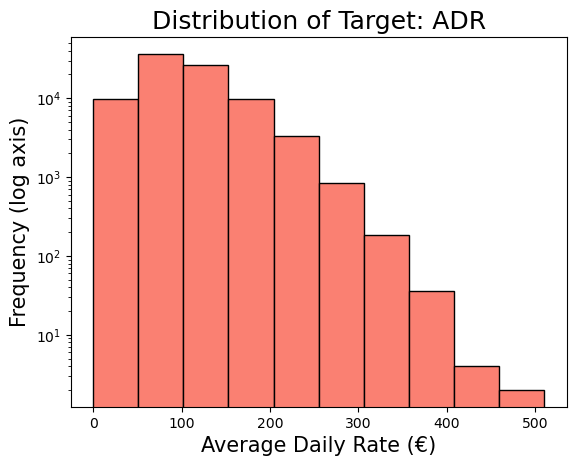

In [38]:
#plotting distribution of target: HISTOGRAM
plt.title("Distribution of Target: ADR", fontsize= 18)
plt.xlabel('Average Daily Rate (€)',fontsize= 15)
plt.ylabel('Frequency (log axis)',fontsize= 15)
plt.hist(df['adr'], color = 'salmon', edgecolor = 'black' )
plt.semilogy()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/adr_Histogram_Distriubtion.png', dpi = 300)
plt.show()

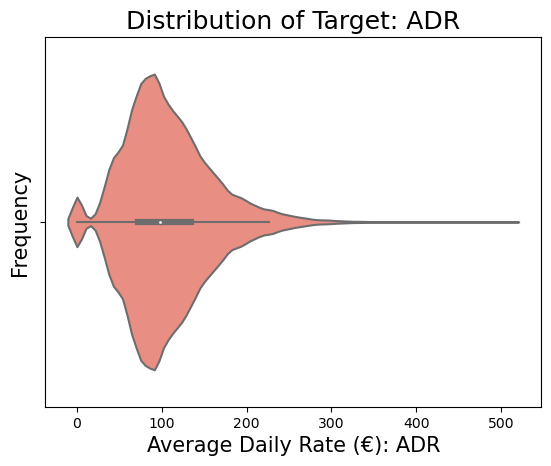

In [39]:
#plotting distribution of target: VIOLINPLOT
sns.violinplot(df['adr'], orient='h' , color = 'salmon')

plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Average Daily Rate (€): ADR', fontsize = 15)
plt.title('Distribution of Target: ADR', fontsize = 18)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/adr - Violin Distriubtion.png', dpi = 300)
plt.show()

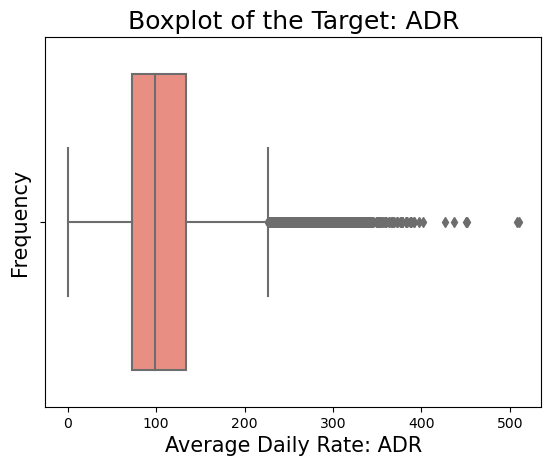

In [40]:
#plotting distribution of target:BOXPLOT
sns.boxplot(x= df['adr'], color = 'salmon')
plt.title('Boxplot of the Target: ADR', fontsize = 18)

plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Average Daily Rate: ADR', fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/adr - Boxplot Distribution.png', dpi = 300)
plt.show()

<a id = 'ms'></a>

> ### 4.2 &ensp; market_segment

In [41]:
#seeing general sense of values
df['market_segment'].describe()

count         86942
unique            8
top       Online TA
freq          51544
Name: market_segment, dtype: object

In [42]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['market_segment'].value_counts(), '%Count' : round(df['market_segment'].value_counts(normalize = True),5)*100})
count_num.rename_axis('Market Segments')

Counts  %Count
Market Segments                
Online TA         51544  59.286
Offline TA/TO     13856  15.937
Direct            11648  13.397
Groups             4936   5.677
Corporate          4031   4.636
Complementary       698   0.803
Aviation            227   0.261
Undefined             2   0.002

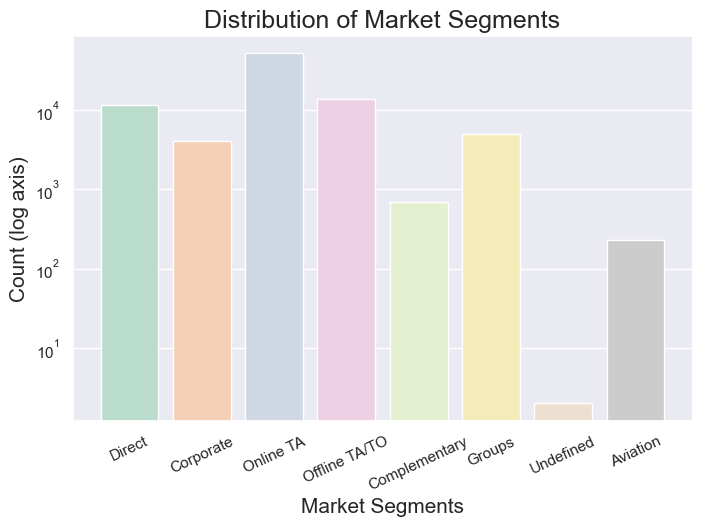

In [43]:
#distribution of market_segment
sns.set(rc={"figure.figsize":(8, 5)})
cplot = sns.countplot(x= df['market_segment'],palette = 'Pastel2')
plt.title( 'Distribution of Market Segments', fontsize = 18)
plt.semilogy()
plt.xlabel("Market Segments",fontsize = 15)
plt.xticks(rotation = 25)
plt.ylabel('Count (log axis)',fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/market_segment Countplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'rrt'></a>

> ### 4.3 &ensp; reserved_room_type

In [44]:
#seeing general sense of values
df['reserved_room_type'].describe()

count     86942
unique       10
top           A
freq      56187
Name: reserved_room_type, dtype: object

In [45]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['reserved_room_type'].value_counts(), '%Count' : round(df['reserved_room_type'].value_counts(normalize = True),5)*100})
count_num.rename_axis('reserved_room_type')

Counts  %Count
reserved_room_type                
A                    56187  64.626
D                    17370  19.979
E                     6012   6.915
F                     2816   3.239
G                     2041   2.348
B                      999   1.149
C                      914   1.051
H                      596   0.686
L                        6   0.007
P                        1   0.001

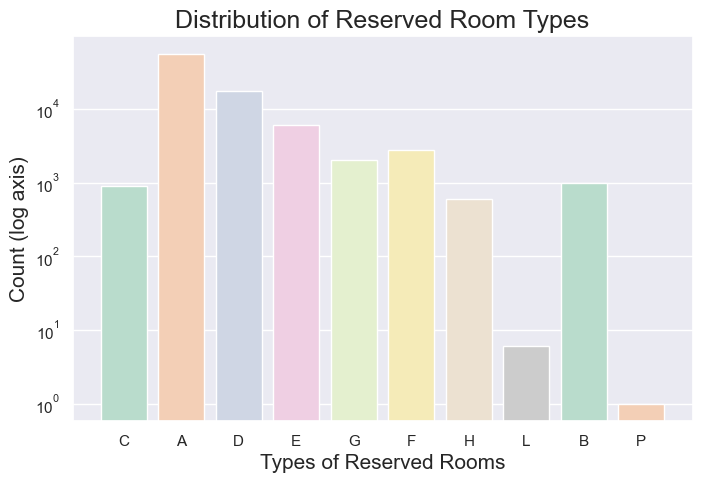

In [46]:
#distribution of reserved_room_type
cplot = sns.countplot(x= df['reserved_room_type'],palette = 'Pastel2')
plt.title('Distribution of Reserved Room Types', fontsize = 18)
plt.semilogy()
plt.xlabel("Types of Reserved Rooms",fontsize = 15)
plt.ylabel('Count (log axis)',fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/reserved_room_type Countplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'ast'></a>

> ### 4.4 &ensp; assigned_room_type

In [47]:
#seeing general sense of values
df['assigned_room_type'].describe()

count     86942
unique       12
top           A
freq      46150
Name: assigned_room_type, dtype: object

In [48]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['assigned_room_type'].value_counts(), '%Count' : round(df['assigned_room_type'].value_counts(normalize = True),5)*100})
count_num.rename_axis('assigned_room_type')

Counts  %Count
assigned_room_type                
A                    46150  53.081
D                    22278  25.624
E                     7128   8.199
F                     3608   4.150
G                     2484   2.857
C                     2144   2.466
B                     1820   2.093
H                      701   0.806
I                      351   0.404
K                      276   0.317
L                        1   0.001
P                        1   0.001

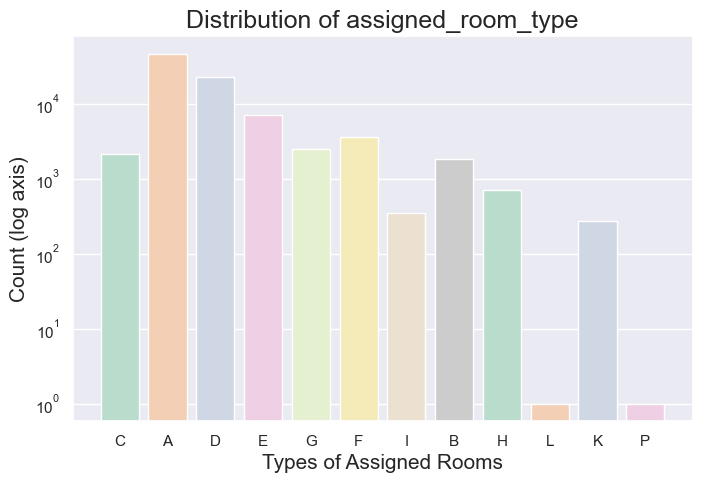

In [49]:
#distribution of assigned_room_type
cplot = sns.countplot(x= df['assigned_room_type'],palette = 'Pastel2')
plt.title ('Distribution of assigned_room_type',fontsize = 18)
plt.semilogy()
plt.xlabel("Types of Assigned Rooms",fontsize = 15)
plt.ylabel('Count (log axis)',fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/assigned_room_type Countplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'children'></a>

> ### 4.5 &ensp; children

In [50]:
#seeing general sense of values
df['children'].describe()

count    86938.000000
mean         0.139214
std          0.456791
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: children, dtype: float64

In [51]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['children'].value_counts(), '%Count' : round(df['children'].value_counts(normalize = True),5)*100})
count_num.rename_axis('children')

Counts  %Count
children                
0.0        78585  90.392
1.0         4686   5.390
2.0         3591   4.131
3.0           75   0.086
10.0           1   0.001

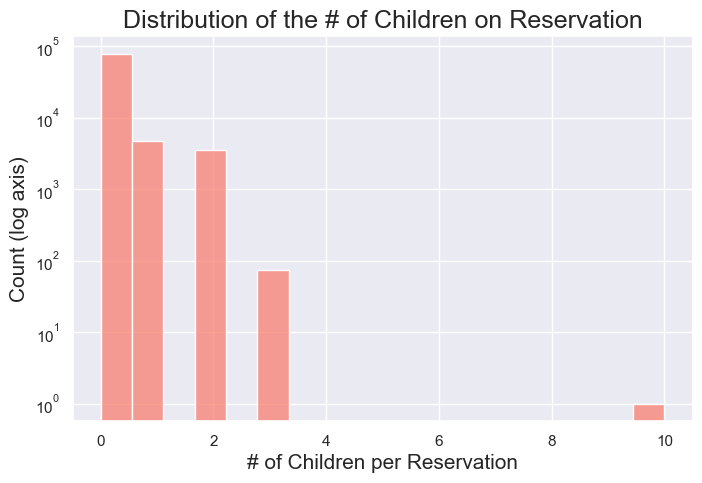

In [52]:
#distribution of assigned_room_type
cplot = sns.histplot(x= df['children'],color = 'salmon')
plt.title('Distribution of the # of Children on Reservation', fontsize = 18)
plt.semilogy()
plt.xlabel("# of Children per Reservation",fontsize = 15)
plt.ylabel('Count (log axis)', fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/children Countplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'agent'></a>

> ### 4.6 &ensp; agent

In [53]:
#seeing general sense of values
df['agent'].describe()

count    86942.000000
mean        81.107221
std        109.942765
min          0.000000
25%          9.000000
50%          9.000000
75%        240.000000
max        535.000000
Name: agent, dtype: float64

In [54]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['agent'].value_counts(), '%Count' : round(df['agent'].value_counts(normalize = True),5)*100})
count_num.rename_axis('agent')

Counts  %Count
agent                
9.0     28758  33.077
240.0   12977  14.926
0.0     11868  13.650
14.0     3348   3.851
7.0      3300   3.796
...       ...     ...
257.0       1   0.001
291.0       1   0.001
93.0        1   0.001
483.0       1   0.001
449.0       1   0.001

[333 rows x 2 columns]

In [55]:
## distriubtion of agent: pie plot


#top 5 highest res by agent

agent_data = zip(count_num.index.values[0:5],count_num.iloc[:5,0],count_num.iloc[:5,1])
agent_df = pd.DataFrame(agent_data, columns = ('Agent ID','Counts','%Counts'))
sum_of_rest = sum(count_num.iloc[5:,0])
percent_of_rest =sum(count_num.iloc[5:,1])
agent_df1 = agent_df.loc[len(agent_df.index)] = [9999, sum_of_rest, percent_of_rest]
agent_df.append(agent_df1)

fig = px.pie(agent_df,
             values="Counts",
             names="Agent ID",
             title="# of Reservations booked by Agent",
             template="seaborn",width=1000, height=800)
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

fig.write_image("figures/reservations_by_agent.png")

print('Note: ID: 9999, is a dummy ID that is an aggregate of all agents who are not in the top 5')

Note: ID: 9999, is a dummy ID that is an aggregate of all agents who are not in the top 5


<a id = 'lead'></a>

> ### 4.7 &ensp; lead_time

In [56]:
#seeing general sense of values
df['lead_time'].describe()

count    86942.000000
mean        80.189023
std         86.099734
min          0.000000
25%         12.000000
50%         50.000000
75%        125.000000
max        737.000000
Name: lead_time, dtype: float64

In [57]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['lead_time'].value_counts(), '%Count' : round(df['lead_time'].value_counts(normalize = True),5)*100})
count_num.rename_axis('lead_time')

Counts  %Count
lead_time                
0            5862   6.742
1            3152   3.625
2            1892   2.176
3            1690   1.944
4            1552   1.785
...           ...     ...
410             1   0.001
411             1   0.001
371             1   0.001
532             1   0.001
463             1   0.001

[479 rows x 2 columns]

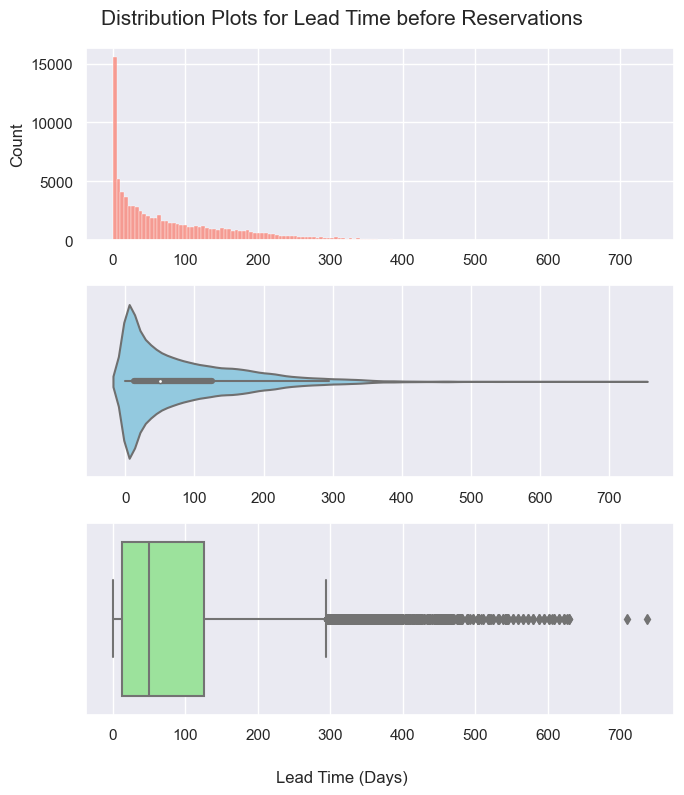

In [58]:
#violin plot/box plot/barplot
fig, ax = plt.subplots(3,1, figsize=(7, 8))

h = sns.histplot(x = df['lead_time'],ax=ax[0], color = 'salmon')
v = sns.violinplot(x=df['lead_time'],ax=ax[1], color='skyblue')
b = sns.boxplot(x = df['lead_time'],ax=ax[2], color = 'lightgreen')

#creating log axis



#setting equal axis
ax[2]=ax[0].twinx
ax[1]=ax[0].twinx

#getting rid of labels
h.set(xlabel=None)
v.set(xlabel = None)
b.set(xlabel = None)

#creating super labels
fig.supxlabel('Lead Time (Days)',fontsize=12)
fig.suptitle('Distribution Plots for Lead Time before Reservations',fontsize=15)
#fig.supylabel('Count')
fig.tight_layout()

plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/lead_time subplots Distriubtion.png', dpi = 300)
plt.show()

<a id = 'week'></a>

> ### 4.8 &ensp; stay_in_weekend_nights

In [59]:
#seeing general sense of values
df['stays_in_weekend_nights'].describe()

count    86942.000000
mean         1.007361
std          1.028713
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: stays_in_weekend_nights, dtype: float64

In [60]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['stays_in_weekend_nights'].value_counts(), '%Count' : round(df['stays_in_weekend_nights'].value_counts(normalize = True),5)*100})
count_num.rename_axis('# of Weekend Nights')


Counts  %Count
# of Weekend Nights                
0                     34855  40.090
2                     26370  30.331
1                     22559  25.947
4                      1727   1.986
3                      1144   1.316
6                       113   0.130
5                        69   0.079
8                        60   0.069
7                        15   0.017
9                        10   0.012
10                        7   0.008
12                        5   0.006
13                        3   0.003
16                        3   0.003
14                        2   0.002

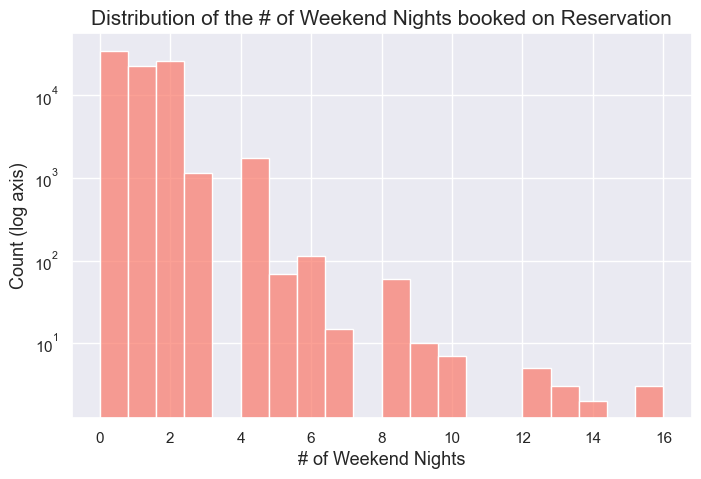

In [61]:
#distribution of assigned_room_type
cplot = sns.histplot(x= df['stays_in_weekend_nights'],color = 'salmon', binwidth  = 0.8)
plt.title('Distribution of the # of Weekend Nights booked on Reservation', fontsize = 15)
plt.semilogy()
plt.xlabel("# of Weekend Nights",fontsize = 13)
plt.ylabel('Count (log axis)', fontsize = 13)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/Weekend_Nights_on_Reservation histplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'weekend'></a>

> ### 4.9 &ensp; stay_in_weekend_nights

In [62]:
#seeing general sense of values
df['stays_in_week_nights'].describe()

count    86942.000000
mean         2.628706
std          2.043728
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         41.000000
Name: stays_in_week_nights, dtype: float64

In [63]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['stays_in_week_nights'].value_counts(), '%Count' : round(df['stays_in_week_nights'].value_counts(normalize = True),5)*100})
count_num.rename_axis('# of Week Nights')

Counts  %Count
# of Week Nights                
1                  21973  25.273
2                  20637  23.737
3                  16221  18.657
5                   9648  11.097
4                   7865   9.046
0                   6130   7.051
6                   1370   1.576
10                   966   1.111
7                    965   1.110
8                    611   0.703
9                    219   0.252
15                    68   0.078
11                    49   0.056
20                    41   0.047
12                    40   0.046
13                    27   0.031
14                    25   0.029
19                    21   0.024
21                    15   0.017
16                    13   0.015
22                     7   0.008
25                     6   0.007
18                     6   0.007
30                     5   0.006
17                     4   0.005
24                     2   0.002
40                     2   0.002
33                     1   0.001
32                     1   0.001
26                     1   0.001
34                     1   0.001
35                     1   0.001
41                     1   0.001

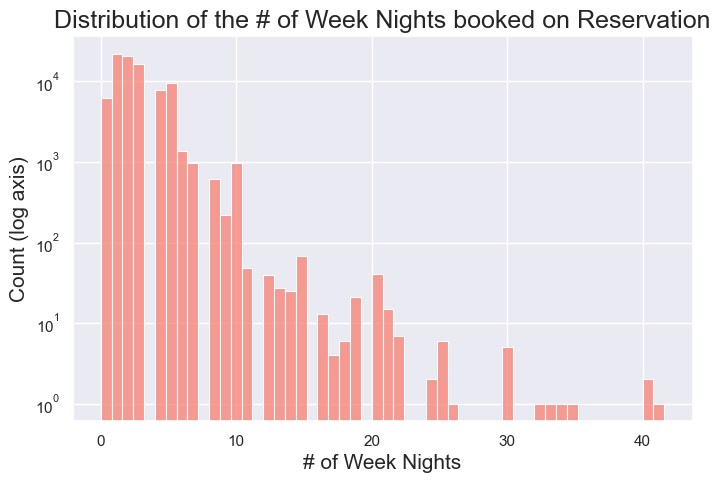

In [64]:
#distribution of assigned_room_type
cplot = sns.histplot(x= df['stays_in_week_nights'],color = 'salmon', binwidth  = 0.8)
plt.title('Distribution of the # of Week Nights booked on Reservation', fontsize = 18)
plt.semilogy()
plt.xlabel("# of Week Nights",fontsize = 15)
plt.ylabel('Count (log axis)', fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/Week_Nights_on_Reservation histplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'deposit'></a>

> ### 4.10 &ensp; deposit_type

In [290]:
#seeing general sense of values
df['deposit_type'].describe()

count         119390
unique             3
top       No Deposit
freq          104641
Name: deposit_type, dtype: object

In [291]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['deposit_type'].value_counts(), '%Count' : round(df['deposit_type'].value_counts(normalize = True),5)*100})
count_num.rename_axis('deposit_type')

Counts  %Count
deposit_type                
No Deposit    104641  87.646
Non Refund     14587  12.218
Refundable       162   0.136

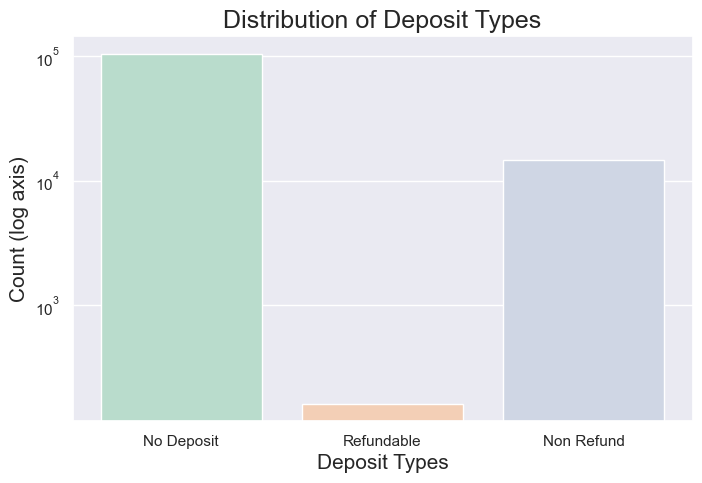

In [292]:
#distribution of assigned_room_type
cplot = sns.countplot(x= df['deposit_type'],palette = 'Pastel2')
plt.title ('Distribution of Deposit Types',fontsize = 18)
plt.semilogy()
plt.xlabel("Deposit Types",fontsize = 15)
plt.ylabel('Count (log axis)',fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/Deposit Countplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'country'></a>

> ### 4.11 &ensp; country

In [293]:
#seeing general sense of values
df['country'].describe()

count     118902
unique       177
top          PRT
freq       48590
Name: country, dtype: object

In [294]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['country'].value_counts(), 'Distribution %' : round(df['country'].value_counts(normalize = True),5)*100})
count_num.rename_axis('country')

Counts  Distribution %
country                        
PRT       48590          40.866
GBR       12129          10.201
FRA       10415           8.759
ESP        8568           7.206
DEU        7287           6.129
...         ...             ...
DJI           1           0.001
BWA           1           0.001
HND           1           0.001
VGB           1           0.001
NAM           1           0.001

[177 rows x 2 columns]

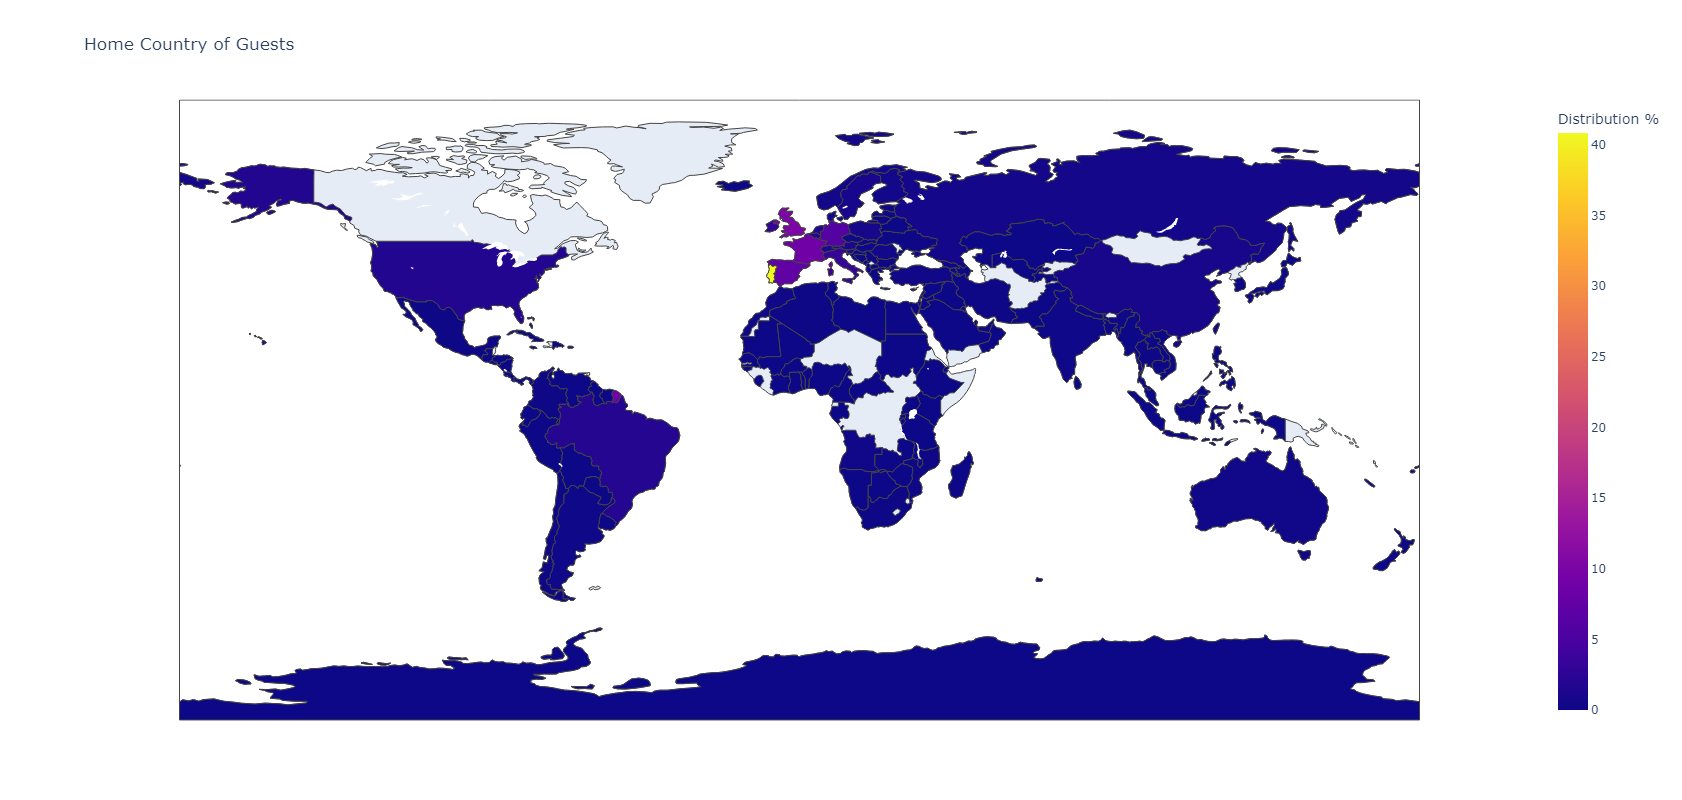

In [295]:
#Distribution of guests by country
guest_map = px.choropleth(count_num,
                    locations=count_num.index,
                    color=count_num["Distribution %"],  
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home Country of Guests",width=1000, height=800)
guest_map.show()
guest_map.write_image('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/Guest Home Country Distriubtion.png')

<a id = 'waiting'><a/>

> ### 4.11 &ensp; days_in_waiting_list

In [71]:
#seeing general sense of values
df['days_in_waiting_list'].describe()

count    86942.000000
mean         0.753479
std         10.041701
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        391.000000
Name: days_in_waiting_list, dtype: float64

In [72]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['days_in_waiting_list'].value_counts(), '%Count' : round(df['days_in_waiting_list'].value_counts(normalize = True),5)*100})
count_num.rename_axis('Days in WaitList')

Counts  %Count
Days in WaitList                
0                  86082  99.011
63                    53   0.061
87                    25   0.029
44                    23   0.026
15                    22   0.025
...                  ...     ...
79                     1   0.001
120                    1   0.001
160                    1   0.001
85                     1   0.001
36                     1   0.001

[128 rows x 2 columns]

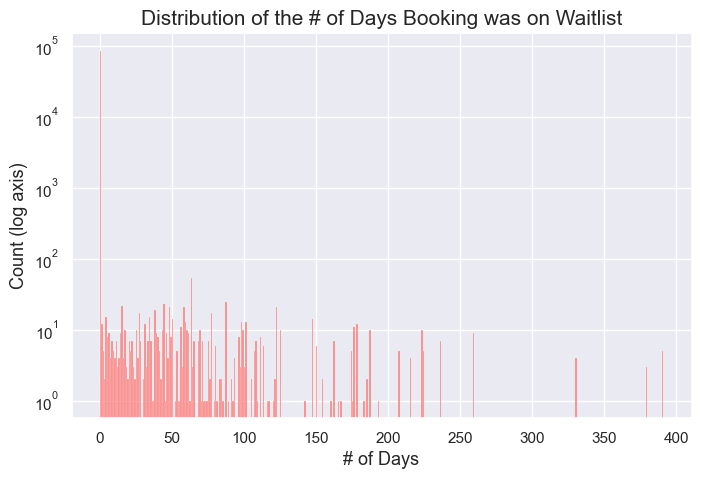

In [73]:
#distribution of number of days on wait list
cplot = sns.histplot(x= df['days_in_waiting_list'],color = '#FF6D6A', binwidth  = 1.0)
plt.title('Distribution of the # of Days Booking was on Waitlist', fontsize = 15)
plt.semilogy()
plt.xlabel("# of Days",fontsize = 13)
plt.ylabel('Count (log axis)', fontsize = 13)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/DaysOnWaitlist histplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'meal'><a/>

> ### 4.12 &ensp; meal

In [74]:
#seeing general sense of values
df['meal'].describe()

count     86942
unique        5
top          BB
freq      67564
Name: meal, dtype: object

In [75]:
#identifying counts for each value
count_num = pd.DataFrame({ 'Counts' : df['meal'].value_counts(), '%Count' : round(df['meal'].value_counts(normalize = True),5)*100})
count_num.rename_axis('Meal Type')

Counts  %Count
Meal Type                
BB          67564  77.712
SC           9474  10.897
HB           9056  10.416
Undefined     488   0.561
FB            360   0.414

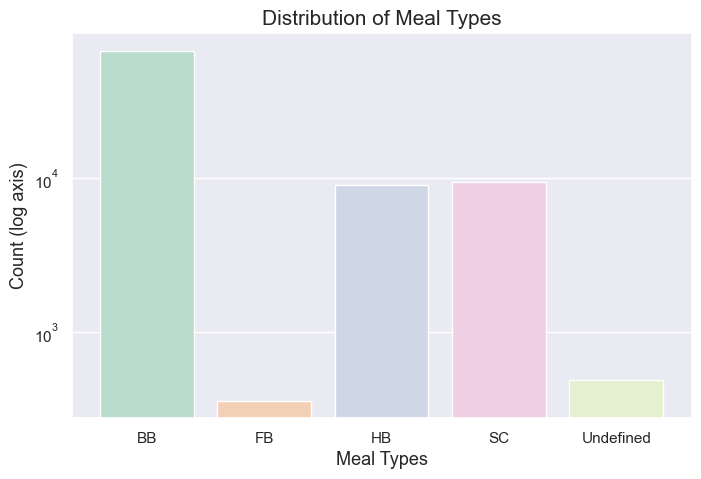

In [76]:
#distribution of assigned_room_type
cplot = sns.countplot(x= df['meal'],palette = 'Pastel2')
plt.title ('Distribution of Meal Types',fontsize = 15)
plt.semilogy()
plt.xlabel("Meal Types",fontsize = 13)
plt.ylabel('Count (log axis)',fontsize = 13)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/meal type Countplot Distriubtion.png', dpi = 300)
plt.show()

<a id = 'multieda'><a/>

## 5.  Multivariate EDA

C:\Users\stuar\AppData\Local\Temp\ipykernel_32944\3216997217.py:38: UserWarning:

FixedFormatter should only be used together with FixedLocator



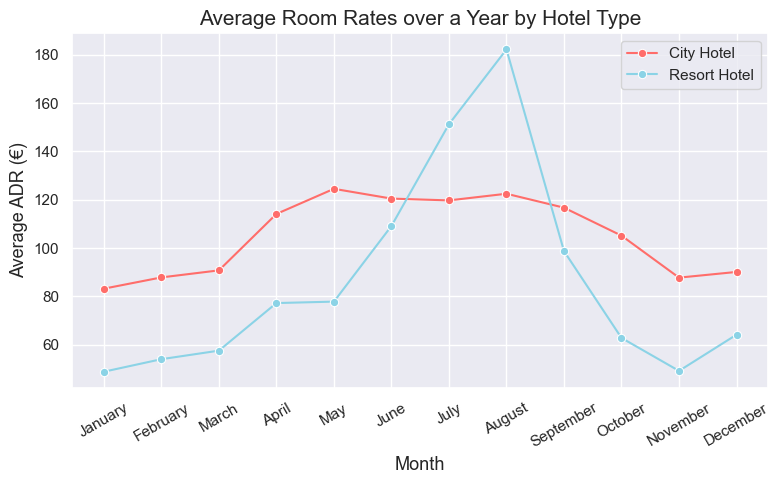

In [77]:
##(avg.) ADR vs Arrival Month by Hotel type

#getting only average adr of reservations that did not cancel
no_cancel = df[df['is_canceled'] == 0]

#setting order for x ticks
ordered_month = ['January', 'February', 'March', 'April','May','June','July','August','September','October','November','December']

#create a new dataframe: adr_month
adr_orderedMonth = pd.DataFrame(ordered_month, columns=['Month'])

#populating resort adr
resort_adr = []
for x in range(len(adr_orderedMonth)):
    no_cancel_r = no_cancel[no_cancel['hotel'] == 'Resort Hotel']
    avg = np.mean(no_cancel_r[no_cancel_r['arrival_date_month'] == adr_orderedMonth.iloc[x,0]]['adr']) 
    resort_adr.append(avg)
adr_orderedMonth['Resort_adr'] = resort_adr
                            
#populating city adr
city_adr = []
for x in range(len(adr_orderedMonth)):
    no_cancel_r = no_cancel[no_cancel['hotel'] == 'City Hotel']
    avg = np.mean(no_cancel_r[no_cancel_r['arrival_date_month'] == adr_orderedMonth.iloc[x,0]]['adr']) 
    city_adr.append(avg)
adr_orderedMonth['City_adr'] = city_adr
    
#define figure size
fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(8, 5)})

#creating lineplot
sns.lineplot(data =adr_orderedMonth, x = 'Month', y = 'City_adr', color = '#FF6D6A', marker='o',ax = ax)
sns.lineplot(data =adr_orderedMonth, x = 'Month', y = 'Resort_adr', color = '#8BD3E6', marker='o',ax = ax)

#dressing the plot
ax.legend(['City Hotel','Resort Hotel'])
ax.set_xticklabels(ordered_month, rotation=30)
ax.set_title('Average Room Rates over a Year by Hotel Type', fontsize = 15)
ax.set_ylabel('Average ADR (€)',fontsize = 13)
ax.set_xlabel('Month', fontsize = 13)
plt.tight_layout()

plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/average adr over time lineplot.png', dpi = 300)

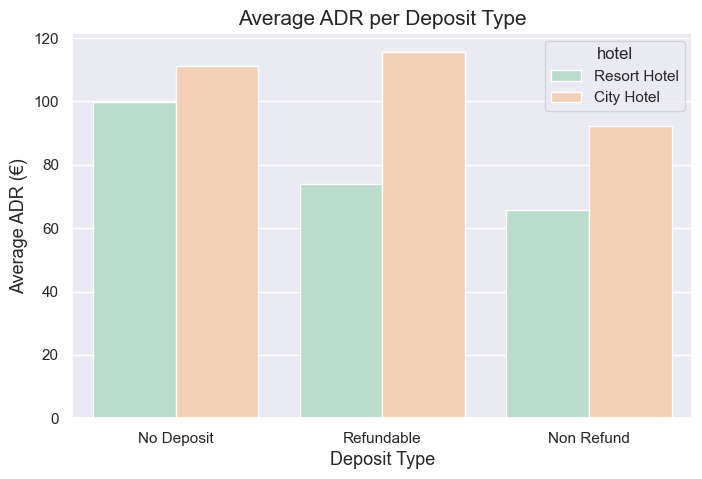

<Figure size 800x500 with 0 Axes>

In [78]:
#distribution of reserved_room_type
cplot = sns.barplot(x= df['deposit_type'], y = df['adr'],palette = 'Pastel2', hue = df['hotel'], ci = None)
plt.title('Average ADR per Deposit Type', fontsize = 15)

plt.xlabel("Deposit Type",fontsize = 13)
plt.ylabel('Average ADR (€)',fontsize = 13)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/deposit vs adr .png', dpi = 300)
plt.show()

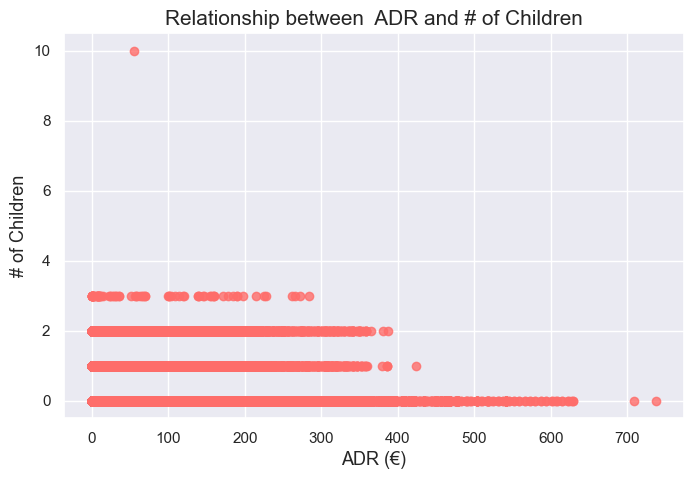

In [79]:
## Lead time vs ADR
plt.scatter(df['lead_time'],df['children'], alpha=0.8, color = '#FF6D6A' )
plt.title('Relationship between  ADR and # of Children', fontsize = 15)
plt.xlabel('ADR (€)', fontsize = 13)
plt.ylabel('# of Children', fontsize = 13)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/children vs adr.png', dpi = 300)
plt.show()

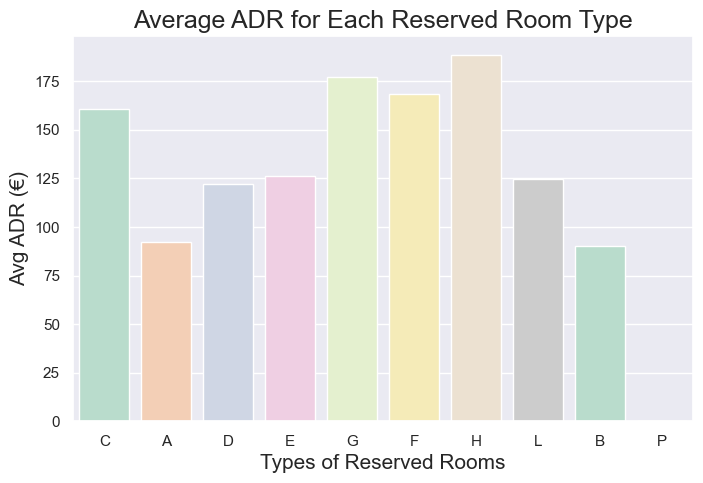

In [80]:
#reserved_room_type vs adr
cplot = sns.barplot(x= df['reserved_room_type'],y = df['adr'],palette = 'Pastel2', ci = None)
plt.title('Average ADR for Each Reserved Room Type', fontsize = 18)
plt.xlabel("Types of Reserved Rooms",fontsize = 15)
plt.ylabel('Avg ADR (€)',fontsize = 15)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/reserved_room_type vs avg adr Distriubtion.png', dpi = 300)
plt.show()

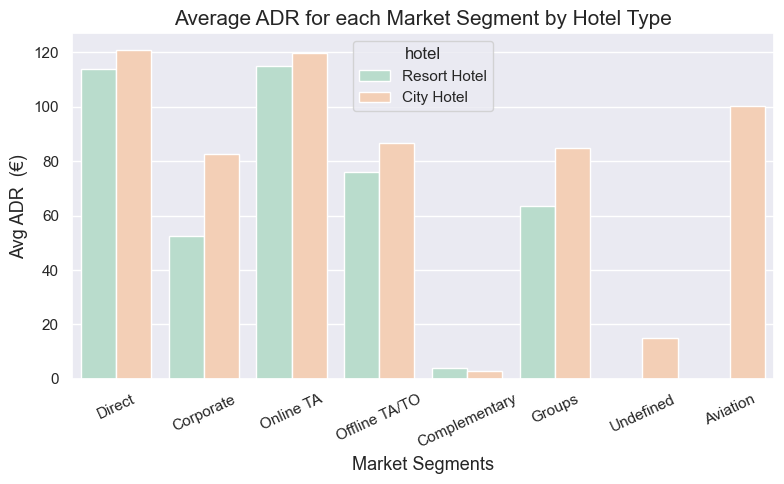

In [81]:
#distribution of market Segment
sns.set(rc={"figure.figsize":(8, 5)})
cplot = sns.barplot(x= df['market_segment'],y = df['adr'],palette = 'Pastel2', hue = df['hotel'], ci = None)
plt.title( 'Average ADR for each Market Segment by Hotel Type', fontsize = 15)
sns.move_legend(ax, "center right")
plt.xlabel("Market Segments",fontsize = 13)
plt.xticks(rotation = 25)
plt.ylabel('Avg ADR  (€)',fontsize = 13)
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/market_segment vs adr.png', dpi = 300)
plt.show()

C:\Users\stuar\AppData\Local\Temp\ipykernel_32944\2646087141.py:38: UserWarning:

FixedFormatter should only be used together with FixedLocator



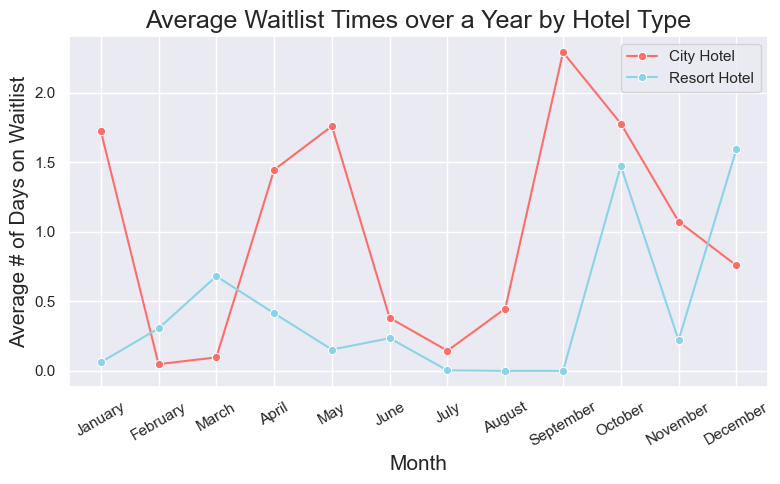

In [82]:
##(avg.) waitlist vs Arrival Month by Hotel type

#getting only average waitlist of reservations that did not cancel
no_cancel = df[df['is_canceled'] == 0]

#setting order for x ticks
ordered_month = ['January', 'February', 'March', 'April','May','June','July','August','September','October','November','December']

#create a new dataframe: waitlist_month
waitlist_orderedMonth = pd.DataFrame(ordered_month, columns=['Month'])

#populating resort waitlist
resort_waitlist = []
for x in range(len(waitlist_orderedMonth)):
    no_cancel_r = no_cancel[no_cancel['hotel'] == 'Resort Hotel']
    avg = np.mean(no_cancel_r[no_cancel_r['arrival_date_month'] == waitlist_orderedMonth.iloc[x,0]]['days_in_waiting_list']) 
    resort_waitlist.append(avg)
waitlist_orderedMonth['Resort_waitlist'] = resort_waitlist
                            
#populating city waitlist
city_waitlist = []
for x in range(len(waitlist_orderedMonth)):
    no_cancel_r = no_cancel[no_cancel['hotel'] == 'City Hotel']
    avg = np.mean(no_cancel_r[no_cancel_r['arrival_date_month'] == waitlist_orderedMonth.iloc[x,0]]['days_in_waiting_list']) 
    city_waitlist.append(avg)
waitlist_orderedMonth['City_waitlist'] = city_waitlist
    
#define figure size
fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(8, 5)})

#creating lineplot
sns.lineplot(data =waitlist_orderedMonth, x = 'Month', y = 'City_waitlist', color = '#FF6D6A', marker='o',ax = ax)
sns.lineplot(data =waitlist_orderedMonth, x = 'Month', y = 'Resort_waitlist', color = '#8BD3E6', marker='o',ax = ax)

#dressing the plot
ax.legend(['City Hotel','Resort Hotel'])
ax.set_xticklabels(ordered_month, rotation=30)
ax.set_title('Average Waitlist Times over a Year by Hotel Type', fontsize = 18)
ax.set_ylabel('Average # of Days on Waitlist',fontsize = 15)
ax.set_xlabel('Month', fontsize = 15)
plt.tight_layout()

plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/average waitlist over time lineplot.png', dpi = 300)

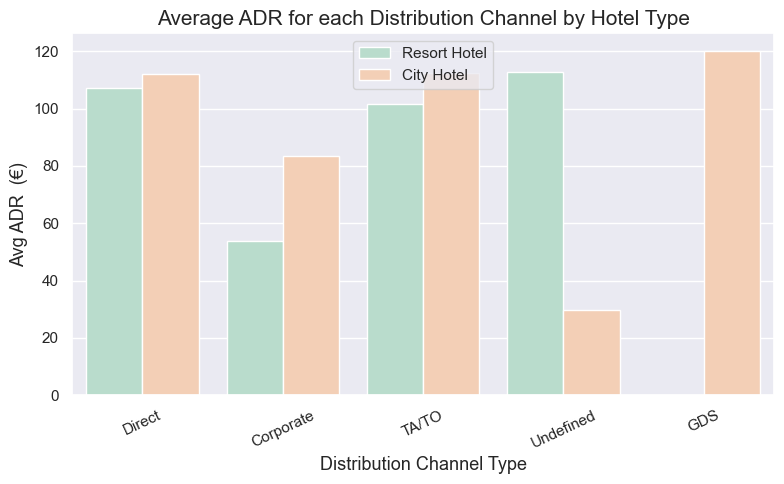

In [83]:
#distribution of distribution channel
sns.set(rc={"figure.figsize":(8, 5)})
cplot = sns.barplot(x= df['distribution_channel'],y = df['adr'],palette = 'Pastel2', hue = df['hotel'], ci = None)
plt.title( 'Average ADR for each Distribution Channel by Hotel Type', fontsize = 15)
plt.legend(loc='upper center')
plt.xlabel("Distribution Channel Type",fontsize = 13)
plt.xticks(rotation = 25)
plt.ylabel('Avg ADR  (€)',fontsize = 13)
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/figures/distribution channel vs adr.png', dpi = 300)
plt.show()

<a id = 'modeling'><a/>

## 6.  Modeling

**PIPELINE FOR EACH ML ALGO**

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [85]:
#ml pipeline with preprocessing


def MLpipe_KFold_RMSE_prep(X,y,preprocessor,ML_algo,param_grid):
    
    #set random states
    random_states = [i+1 for i in range(5)] #random states 
    
    #create empty lists to store different metrics
    baseline_scores = []
    test_scores = []
    best_models = []
    
    for random_state in random_states:

        #split the data 80/20
        X_train, X_test, y_train, y_test = tts_rs(X,y,train_size=0.8,random_state = 13*random_state)

        #Implement KFold = 4
        kf = KFold(n_splits = 4, shuffle = True, random_state = 13*random_state)

        #Preprocess the data and perform cross validation
        pipeline = make_pipeline(preprocessor,ML_algo)

        #Use GridSearch to loop through all parameter combinations
        gridCV = GridSearchCV(pipeline, param_grid = param_grid, \
                              scoring = 'neg_root_mean_squared_error',cv=kf,\
                              return_train_score = True, n_jobs=-1, verbose=True)

        #print(gridCV.estimator.get_params().keys())

        #fit the model on the training set
        gridCV.fit(X_train,y_train)

        #save results in a df
        #result = pd.DataFrame(gridCV.cv_results_)
        #print(result)

        #store the best_params
        #best_params.append(gridCV.best_params_)
        best_models.append(gridCV.best_estimator_)
        #print('Best Parameters:', grid.best_params_)
        #print('RMSE score:',grid.best_score_)


        #bunch of print statements
        #print(gridCV)
        #print(gridCV.best_params_)
        #print(best_models)
        #print(gridCV.best_params_)
        #print(gridCV.best_estimator_)
        
        #calculating the the baseline score
        y_test_mean = np.mean(y_test)
        y_test_baseline = np.full(len(y_test), y_test_mean)
        baseline_scores.append(mean_squared_error(y_test,  y_test_baseline, squared = False))


        #calculate and save the test score
        y_test_pred = gridCV.predict(X_test) 
        test_scores.append(mean_squared_error(y_test,y_test_pred, squared = False))
        
        
        
    #outputting metrics in a table
    metrics = {'Score Type': ['Baseline', 'Test'],
               'RMSE Mean':[np.mean(baseline_scores), np.mean(test_scores)],
               'RMSE Std Dev.':[np.std(baseline_scores), np.std(test_scores)]
    }
    metric_df = pd.DataFrame.from_dict(metrics)
        

    return best_models, test_scores, baseline_scores, metric_df

<a id = 'lasso'><a/>

###  *6.1  &ensp; Linear Regression w. L1 Regularization (Lasso)*

In [86]:
#import packages
from  sklearn.linear_model import Lasso

In [87]:
#city hotel

#defining parameters
param_grid_l1 = {
    'lasso__alpha': np.logspace(-4,4,9),
    'lasso__max_iter':[100000]
}

#creating lasso object
lasso = Lasso()

#finding best models and test/baseline scores
c_lasso_models,c_lasso_test_scores, c_lasso_baseline_scores, c_lasso_metric_df = MLpipe_KFold_RMSE_prep(city_X,city_y,preprocessor,lasso,param_grid_l1)  #city_X, city_y



#printing out basic baseline and test score metrics
print(c_lasso_metric_df)
print('\n')

#printing best model
print("Best Model:", c_lasso_models[np.argmin(c_lasso_test_scores)], ' ', 'Best RMSE:' , min(c_lasso_test_scores))
print('\n')



#printing test scores and standard deviations away from baseline"
c_lasso_stnd_dev_test_baseline =  [(c_lasso_test_scores[x]-c_lasso_baseline_scores[x])/np.std(c_lasso_baseline_scores) for x in range(len(c_lasso_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(c_lasso_stnd_dev_test_baseline) )
print('\n')



Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  41.434700       0.974120
1       Test  23.572096       0.846638


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_

In [275]:
#saving model
best_lasso_model_city = c_lasso_models[np.argmin(c_lasso_test_scores)]

pickle.dump(best_lasso_model_city, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/lasso_model_city.pkl', 'wb'))

In [88]:

#resort hotel

#defining parameters
param_grid_l1 = {
    'lasso__alpha': np.logspace(-4,4,9),
    'lasso__max_iter':[10000]  
}

#creating lasso object
lasso = Lasso()

#finding best models and test/baseline scores
r_lasso_models,r_lasso_test_scores, r_lasso_baseline_scores, r_lasso_metric_df = MLpipe_KFold_RMSE_prep(resort_X, resort_y,preprocessor,lasso,param_grid_l1) #resort_X, resort_y



#printing out basic baseline and test score metrics
print(r_lasso_metric_df)
print('\n')

#printing best model
print("Best Model:",r_lasso_models[np.argmin(r_lasso_test_scores)], ' ', 'Best RMSE:' , min(r_lasso_test_scores))
print('\n')



#printing test scores and standard deviations away from baseline"
r_lasso_stnd_dev_test_baseline =  [(r_lasso_test_scores[x]-r_lasso_baseline_scores[x])/np.std(r_lasso_baseline_scores) for x in range(len(r_lasso_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(r_lasso_stnd_dev_test_baseline) )
print('\n')


Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  64.317920       1.402861
1       Test  31.004636       1.517769


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_

In [276]:
#saving model
best_lasso_model_resort = r_lasso_models[np.argmin(r_lasso_test_scores)]

pickle.dump(best_lasso_model_resort, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/lasso_model_resort.pkl', 'wb'))

<a id = 'ridge'><a/>

###  *6.2  &ensp; Linear Regression w. L2 Regularization (Ridge)*

In [89]:
#import packages
from  sklearn.linear_model import Ridge

In [90]:

#City Hotel


# Define param_grid for Ridge
param_grid_l2 = {
    'ridge__alpha':np.logspace(-4,4,9),
    'ridge__max_iter':[10000]
}

#initialize Ridge Regression Object
ridge = Ridge()

#finding best models and test/baseline scores
c_ridge_models,c_ridge_test_scores, c_ridge_baseline_scores, c_ridge_metric_df = MLpipe_KFold_RMSE_prep(city_X,city_y,preprocessor,ridge,param_grid_l2)  #city_X, city_y



#printing out basic baseline and test score metrics
print(c_ridge_metric_df)
print('\n')

#printing best model
print("Best Model:", c_ridge_models[np.argmin(c_ridge_test_scores)], ' ', 'Best RMSE:' , min(c_ridge_test_scores))
print('\n')



#printing test scores and standard deviations away from baseline"
c_ridge_stnd_dev_test_baseline =  [(c_ridge_test_scores[x]-c_ridge_baseline_scores[x])/np.std(c_ridge_baseline_scores) for x in range(len(c_ridge_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(c_ridge_stnd_dev_test_baseline) )
print('\n')


Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline   41.43470       0.974120
1       Test   23.66449       0.950034


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_

In [277]:
#saving model
best_ridge_model_city = c_ridge_models[np.argmin(c_ridge_test_scores)]

pickle.dump(best_ridge_model_city, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/ridge_model_city.pkl', 'wb'))

In [91]:

#resort Hotel


# Define param_grid for Ridge
param_grid_l2 = {
    'ridge__alpha':np.logspace(-4,4,9),
    'ridge__max_iter':[10000]
}

#initialize Ridge Regression Object
ridge = Ridge()

#finding best models and test/baseline scores
r_ridge_models,r_ridge_test_scores, r_ridge_baseline_scores, r_ridge_metric_df = MLpipe_KFold_RMSE_prep(resort_X, resort_y,preprocessor,ridge,param_grid_l2)  #resort_X,resort_y



#printing out basic baseline and test score metrics
print(r_ridge_metric_df)
print('\n')

#printing best model
print("Best Model:", r_ridge_models[np.argmin(r_ridge_test_scores)], ' ', 'Best RMSE:' , min(r_ridge_test_scores))
print('\n')



#printing test scores and standard deviations away from baseline"
r_ridge_stnd_dev_test_baseline =  [(r_ridge_test_scores[x]-r_ridge_baseline_scores[x])/np.std(r_ridge_baseline_scores) for x in range(len(r_ridge_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(r_ridge_stnd_dev_test_baseline) )
print('\n')


Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 9 candidates, totalling 36 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline   64.31792       1.402861
1       Test   31.02967       1.462782


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_

In [278]:
#saving model
best_ridge_model_resort = r_ridge_models[np.argmin(r_ridge_test_scores)]

pickle.dump(best_ridge_model_resort, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/ridge_model_resort.pkl', 'wb'))

<a id = 'el'><a/>

###  *6.3  &ensp; Linear Regression w. L3 Regularization (Elasticnet)*

In [92]:
#import packages
from  sklearn.linear_model import ElasticNet

In [93]:

#City Hotel

#Define param_grid
param_grid_en = {
    'elasticnet__alpha': np.logspace(-2,2,5),
    'elasticnet__l1_ratio': np.linspace(0,1,5),
    'elasticnet__max_iter':[10000]
    
}
    
#initialize the classifier
elasticnet = ElasticNet()

#finding best models and test/baseline scores
c_EL_models,c_EL_test_scores, c_EL_baseline_scores, c_EL_metric_df = MLpipe_KFold_RMSE_prep(city_X,city_y,preprocessor,elasticnet,param_grid_en) #city_X, city_y



#printing out basic baseline and test score metrics
print(c_EL_metric_df)
print('\n')

#printing best model
print("Best Model:", c_EL_models[np.argmin(c_EL_test_scores)], ' ', 'Best RMSE:' , min(c_EL_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline"
c_EL_stnd_dev_test_baseline =  [(c_EL_test_scores[x]-c_EL_baseline_scores[x])/np.std(c_EL_baseline_scores) for x in range(len(c_EL_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(c_EL_stnd_dev_test_baseline) )
print('\n')

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  41.434700       0.974120
1       Test  23.671337       0.931542


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                  

In [280]:
#saving model
best_elasticnet_model_city = c_EL_models[np.argmin(c_EL_test_scores)]

pickle.dump(best_elasticnet_model_city, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/elasticnet_model_city.pkl', 'wb'))

In [94]:

#resort Hotel


#Define param_grid
param_grid_en = {
    'elasticnet__alpha': np.logspace(-2,2,5),
    'elasticnet__l1_ratio': np.linspace(0,1,5),
    'elasticnet__max_iter':[100000]
}

#initialize EL Regression Object
elasticnet = ElasticNet()

#finding best models and test/baseline scores
r_EL_models,r_EL_test_scores, r_EL_baseline_scores, r_EL_metric_df = MLpipe_KFold_RMSE_prep(resort_X, resort_y,preprocessor,elasticnet,param_grid_en)  #resort_X,resort_y



#printing out basic baseline and test score metrics
print(r_EL_metric_df)
print('\n')

#printing best model
print("Best Model:", r_EL_models[np.argmin(r_EL_test_scores)], ' ', 'Best RMSE:' , min(r_EL_test_scores))
print('\n')



#printing test scores and standard deviations away from baseline"
r_EL_stnd_dev_test_baseline =  [(r_EL_test_scores[x]-r_EL_baseline_scores[x])/np.std(r_EL_baseline_scores) for x in range(len(r_EL_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(r_EL_stnd_dev_test_baseline) )
print('\n')


Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  64.317920       1.402861
1       Test  31.004636       1.517769


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                  

In [281]:
#saving model
best_elasticnet_model_resort = r_EL_models[np.argmin(r_EL_test_scores)]

pickle.dump(best_elasticnet_model_resort, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/elasticnet_model_resort.pkl', 'wb'))

<a id = 'svr'><a/>

###  *6.4  &ensp; Support Vector Regression*

In [95]:
#import packages
from sklearn.svm import SVR

In [96]:
#City Hotel

#Define param_grid
param_grid_svr={
    'svr__C':np.logspace(-2,2,5),
    'svr__gamma':np.logspace(-2,2,5)
}

#initialize the classifier
svr = SVR()


#finding best modsvrs and test/bassvrine scores
c_svr_models,c_svr_test_scores, c_svr_baseline_scores, c_svr_metric_df  = MLpipe_KFold_RMSE_prep(city_X,city_y,preprocessor,svr,param_grid_svr) #city_X, city_y



#printing out basic baseline and test score metrics
print(c_svr_metric_df)
print('\n')

#printing best models
print("Best Model:", c_svr_models[np.argmin(c_svr_test_scores)], ' ', 'Best RMSE:' , min(c_svr_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline
c_svr_stnd_dev_test_baseline =  [(c_svr_test_scores[x]-c_svr_baseline_scores[x])/np.std(c_svr_baseline_scores) for x in range(len(c_svr_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(c_svr_stnd_dev_test_baseline) )
print('\n')

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  41.434700       0.974120
1       Test  21.532314       0.989732


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                  

In [282]:
#saving model
best_svr_model_city = c_svr_models[np.argmin(c_svr_test_scores)]

pickle.dump(best_svr_model_city, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/svr_model_city.pkl', 'wb'))

In [97]:
#Resort Hotel

#Define param_grid
param_grid_svr={
    'svr__C':np.logspace(-2,2,5),
    'svr__gamma':np.logspace(-2,2,5)
}

#initialize the classifier
svr = SVR()

#finding best models and test/baseline scores
r_svr_models,r_svr_test_scores, r_svr_baseline_scores, r_svr_metric_df = MLpipe_KFold_RMSE_prep(resort_X, resort_y,preprocessor, svr,param_grid_svr) #resort_X, resort_y



#printing out basic baseline and test score metrics
print(r_svr_metric_df)
print('\n')

#printing best model
print("Best Model:", r_svr_models[np.argmin(r_svr_test_scores)], ' ', 'Best RMSE:' , min(r_svr_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline"
r_svr_stnd_dev_test_baseline =  [(r_svr_test_scores[x]-r_svr_baseline_scores[x])/np.std(r_svr_baseline_scores) for x in range(len(r_svr_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(r_svr_stnd_dev_test_baseline) )
print('\n')

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Fitting 4 folds for each of 25 candidates, totalling 100 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  64.317920       1.402861
1       Test  24.498584       2.116242


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                  

In [283]:
#saving model
best_svr_model_resort = r_svr_models[np.argmin(r_svr_test_scores)]

pickle.dump(best_svr_model_resort, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/svr_model_resort.pkl', 'wb'))

<a id = 'rfr'><a/>

###  *6.5  &ensp; Random Forest Regression*

In [98]:
#import package
from sklearn.ensemble import RandomForestRegressor

In [99]:

#City Hotel

#Define param_grid
param_grid_rf={
    'randomforestregressor__max_depth':[5,10,50,100],
    'randomforestregressor__max_features':[0.75,1.0]
}
    
#initialize the classifier
rf = RandomForestRegressor()    

#finding best models and test/baseline scores
c_rf_models,c_rf_test_scores, c_rf_baseline_scores, c_rf_metric_df = MLpipe_KFold_RMSE_prep(city_X,city_y,preprocessor,rf,param_grid_rf) #city_X, city_y



#printing out basic baseline and test score metrics
print(c_rf_metric_df)
print('\n')

#printing best model
print("Best Model:", c_rf_models[np.argmin(c_rf_test_scores)], ' ', 'Best RMSE:' , min(c_rf_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline"
c_rf_stnd_dev_test_baseline =  [(c_rf_test_scores[x]-c_rf_baseline_scores[x])/np.std(c_rf_baseline_scores) for x in range(len(c_rf_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(c_rf_stnd_dev_test_baseline) )
print('\n')

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  41.434700       0.974120
1       Test  21.191477       0.841366


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_

In [284]:
#saving model
best_rf_model_city = c_rf_models[np.argmin(c_rf_test_scores)]

pickle.dump(best_rf_model_city, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/rf_model_city.pkl', 'wb'))

In [100]:

#Resort Hotel

#Define param_grid
param_grid_rf={
    'randomforestregressor__max_depth':[5,10,50,100],
    'randomforestregressor__max_features':[0.75,1.0]
} 

#initialize the classifier
rf = RandomForestRegressor()    

#finding best models and test/baseline scores
r_rf_models,r_rf_test_scores, r_rf_baseline_scores, r_rf_metric_df = MLpipe_KFold_RMSE_prep(resort_X, resort_y,preprocessor,rf,param_grid_rf) #city_X, city_y



#printing out basic baseline and test score metrics
print(r_rf_metric_df)
print('\n')

#printing best model
print("Best Model:", r_rf_models[np.argmin(r_rf_test_scores)], ' ', 'Best RMSE:' , min(r_rf_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline"
r_rf_stnd_dev_test_baseline =  [(r_rf_test_scores[x]-r_rf_baseline_scores[x])/np.std(r_rf_baseline_scores) for x in range(len(r_rf_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(r_rf_stnd_dev_test_baseline) )
print('\n')

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  64.317920       1.402861
1       Test  23.963223       1.905980


Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('stnd',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_

In [286]:
#saving model
best_rf_model_resort = r_rf_models[np.argmin(r_rf_test_scores)]

pickle.dump(best_rf_model_resort, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/rf_model_resort.pkl', 'wb'))

<a id = 'xgb'><a/>

###  *6.6  &ensp; XGBoost Regression*

In [101]:
#import packages
import xgboost as xgb
from sklearn.model_selection import ParameterGrid

In [102]:
#function for splitting data into 3 sets (train,val,holdout)

def basic_split(X,y,train_size,val_size,test_size,random_state):
    
    # test the inputs
    if train_size+val_size+test_size != 1:
        raise ValueError('partitions must equal to 1!')
    if isinstance(random_state,int) == False:
        raise ValueError('random state must be an integer!')
    
    # perform basic split
    X_train, X_other, y_train, y_other = train_test_split(X,y,\
                                train_size = train_size, random_state = random_state)
    val = val_size/(val_size+test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
                        train_size = val, random_state = random_state)
    
    # test the outputs
    if train_size != round(len(X_train)/(len(X_train)+len(X_val)+len(X_test)),1):
        raise ValueError("X_train and y_train are not the right size!")    
    if val_size != round(len(X_val)/(len(X_train)+len(X_val)+len(X_test)),1):
        raise ValueError("X_val and y_val are not the right size!")
    if test_size != round(len(X_test)/(len(X_train)+len(X_val)+len(X_test)),1):
        raise ValueError("X_test and x_test are not the right size!")

    return X_train, y_train, X_val, y_val, X_test, y_test

In [103]:
#XGB Pipeline

def xgb_pipe(X,y,rs):

    #set random states
    random_states = [i+1 for i in range(5)] #random states 

    baseline_scores = np.zeros(5)
    test_scores = np.zeros(5)  
    
    train_sets = [] #for permutation importance
    test_sets = []
    final_models = []

    for random_state in random_states:

        #########################################PREPROCESSING################################

        #creating split
        X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, .6,.2,.2,rs*random_state)

        #reshaping ys into row vectors for now error messages

        y_train = np.reshape(np.array(y_train), (1, -1)).ravel()
        y_val = np.reshape(np.array(y_val), (1, -1)).ravel()
        y_test = np.reshape(np.array(y_test), (1, -1)).ravel()



        #We already created a column Transformer above


        # fit_transform the training set
        X_prep_train = preprocessor_xgb.fit_transform(X_train)
        # collect feature names
        feature_names = preprocessor_xgb.get_feature_names_out()

        df_train = pd.DataFrame(data=X_prep_train,columns=feature_names)


        # transform the val
        X_prep_val = preprocessor_xgb.transform(X_val)
        df_val = pd.DataFrame(data=X_prep_val,columns = feature_names)

        # transform the test
        X_prep_test = preprocessor_xgb.transform(X_test)
        df_test = pd.DataFrame(data= X_prep_test,columns = feature_names)



        ################################HYPERTUNING#################################        


        #set param grid
        param_grid = {"learning_rate": [0.05],
                  "n_estimators": [10000],
                  "seed": [rs*random_state],
                  "missing": [np.nan], 
                  "max_depth": [1,50,100],
                  "colsample_bytree": [0.75],            
                  "subsample": [0.66],
                  "reg_alpha": [0, 1e-2, 1e0, 1e2],
                  "reg_lambda": [0, 1e-2, 1e0, 1e2],
                  "eval_metric":['rmse'] }

        #best models for validation

        val_models = []
        val_scores = np.zeros(len(ParameterGrid(param_grid)))   


        #Looping throughall possible parameter combinations and appending to val_scores and val_models
        for p in range(len(ParameterGrid(param_grid))): 
            xgbreg = xgb.XGBRegressor()
            params = ParameterGrid(param_grid)[p]
            xgbreg.set_params(**ParameterGrid(param_grid)[p])
            xgbreg.fit(df_train,y_train,early_stopping_rounds=150,\
                         eval_set=[(df_val,y_val)], verbose=False)    
            y_CV_pred = xgbreg.predict(df_val)
            val_scores[p] = mean_squared_error(y_val,y_CV_pred, squared = False)
            val_models.append(xgbreg)


        #appending test set to test_sets list
        
        test_sets.append([X_test, y_test])
        
        #appending X_train to train sets
        train_sets.append(X_train)

        #appending best val_model to best_models and finding test scores                   
        final_models.append(val_models[np.argmin(val_scores)])
        y_test_pred = final_models[-1].predict(df_test)
        test_scores[random_state-1] = mean_squared_error(y_test,y_test_pred, squared = False)


        #finding baseline scores 
        y_test_mean = np.full(len(y_test), np.mean(y_test))
        baseline_scores[random_state-1] = mean_squared_error(y_test,y_test_mean, squared = False)
        
        print( random_state  ,'Random State is Done')
        
    #outputting metrics in a table
    metrics = {'Score Type': ['Baseline', 'Test'],
               'RMSE Mean':[np.mean(baseline_scores), np.mean(test_scores)],
               'RMSE Std Dev.':[np.std(baseline_scores), np.std(test_scores)]
    }
    metric_df = pd.DataFrame.from_dict(metrics)


    return train_sets, test_sets, final_models, test_scores, baseline_scores, metric_df


In [104]:

# City Hotels 

c_train_sets, c_test_sets, c_xgb_best_models,c_xgb_test_scores, c_xgb_baseline_scores, c_xgb_metric_df = xgb_pipe(xgb_city_X, xgb_city_y, 13)

#printing out basic baseline and test score metrics
print(c_xgb_metric_df)
print('\n')

#printing best model
print("Best Model:", c_xgb_best_models[np.argmin(c_xgb_test_scores)], ' ', 'Best RMSE:' , min(c_xgb_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline"
c_xgb_stnd_dev_test_baseline =  [(c_xgb_test_scores[x]-c_xgb_baseline_scores[x])/np.std(c_xgb_baseline_scores) for x in range(len(c_xgb_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(c_xgb_stnd_dev_test_baseline) )
print('\n')

1 Random State is Done
2 Random State is Done
3 Random State is Done
4 Random State is Done
5 Random State is Done
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  41.721958       1.086489
1       Test  19.637920       0.716094


Best Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=100,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=13, reg_alpha=100.0, reg_lambda=1.0,
             scale_pos_weight=1, seed=13, subsample=0.66, tree_method='exact',
             validate_parameters=1, verbosity=None)   Best RMSE: 18.66481016589709


Average Standard Deviation of Test from

In [287]:
#saving model
best_xgb_model_city =  c_xgb_best_models[np.argmin(c_xgb_test_scores)]

pickle.dump(best_xgb_model_city, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/xgb_model_city.pkl', 'wb'))

In [105]:

# Resort Hotels 

r_train_sets, r_test_sets, r_xgb_best_models,r_xgb_test_scores, r_xgb_baseline_scores, r_xgb_metric_df = xgb_pipe(xgb_resort_X, xgb_resort_y, 13)

#printing out basic baseline and test score metrics
print(r_xgb_metric_df)
print('\n')

#printing best model
print("Best Model:", r_xgb_best_models[np.argmin(r_xgb_test_scores)], ' ', 'Best RMSE:' , min(r_xgb_test_scores))
print('\n')


#printing test scores and standard deviations away from baseline"
r_xgb_stnd_dev_test_baseline =  [(r_xgb_test_scores[x]-r_xgb_baseline_scores[x])/np.std(r_xgb_baseline_scores) for x in range(len(r_xgb_test_scores))]
print("Average Standard Deviation of Test from Baseline:",np.mean(r_xgb_stnd_dev_test_baseline) )
print('\n')

1 Random State is Done
2 Random State is Done
3 Random State is Done
4 Random State is Done
5 Random State is Done
  Score Type  RMSE Mean  RMSE Std Dev.
0   Baseline  64.415226       1.430470
1       Test  19.874202       0.900612


Best Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=100,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=26, reg_alpha=100.0,
             reg_lambda=100.0, scale_pos_weight=1, seed=26, subsample=0.66,
             tree_method='exact', validate_parameters=1, verbosity=None)   Best RMSE: 18.6384353988286


Average Standard Deviation of Test fro

In [288]:
#saving model
best_xgb_model_resort =  r_xgb_best_models[np.argmin(r_xgb_test_scores)]

pickle.dump(best_xgb_model_resort, open('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/xgb_model_resort.pkl', 'wb'))

<a id = 'performance'><a/>

## 7.  Performance

<a id = 'best'><a/>

###  *7.1 &ensp; Best Scores*

In [321]:
#all models used 
models = ['Lasso','Ridge','Elasticnet', 'SVR', 'Random Forest', 'XGBoost']

#list of test scores for each model for resort and city hotels
c_perf_model= [c_lasso_test_scores, c_ridge_test_scores, c_EL_test_scores, c_svr_test_scores, c_rf_test_scores, c_xgb_test_scores]
r_perf_model= [r_lasso_test_scores, r_ridge_test_scores, r_EL_test_scores, r_svr_test_scores, r_rf_test_scores, r_xgb_test_scores]


#put average scores/standard deviation into a dataframe with corresponding model

#finding average scores
c_avg_scores = [np.mean(score) for score in c_perf_model]
r_avg_scores = [np.mean(score) for score in r_perf_model]

#finding standard deviations
c_stnddev_scores = [np.std(score) for score in c_perf_model]
r_stnddev_scores = [np.std(score) for score in r_perf_model]


#dataframes for each hotel type

c_scores = pd.DataFrame(zip(models,c_avg_scores,c_stnddev_scores), columns = ['Model','Avg. Test RMSE', 'Stnd Dev.']).sort_values(by = 'Avg. Test RMSE').reset_index(drop = True)
r_scores = pd.DataFrame(zip(models,r_avg_scores,r_stnddev_scores), columns = ['Model','Avg. Test RMSE', 'Stnd Dev.']).sort_values(by = 'Avg. Test RMSE').reset_index(drop = True)
display('City Hotel')
display(c_scores)
print('\n')
display('Resort Hotels')
display(r_scores)

'City Hotel'

Model  Avg. Test RMSE  Stnd Dev.
0        XGBoost       19.637920   0.716094
1  Random Forest       21.191477   0.841366
2            SVR       21.532314   0.989732
3          Lasso       23.572096   0.846638
4          Ridge       23.664490   0.950034
5     Elasticnet       23.671337   0.931542

'Resort Hotels'

Model  Avg. Test RMSE  Stnd Dev.
0        XGBoost       19.874202   0.900612
1  Random Forest       23.963223   1.905980
2            SVR       24.498584   2.116242
3          Lasso       31.004636   1.517769
4     Elasticnet       31.004636   1.517769
5          Ridge       31.029670   1.462782

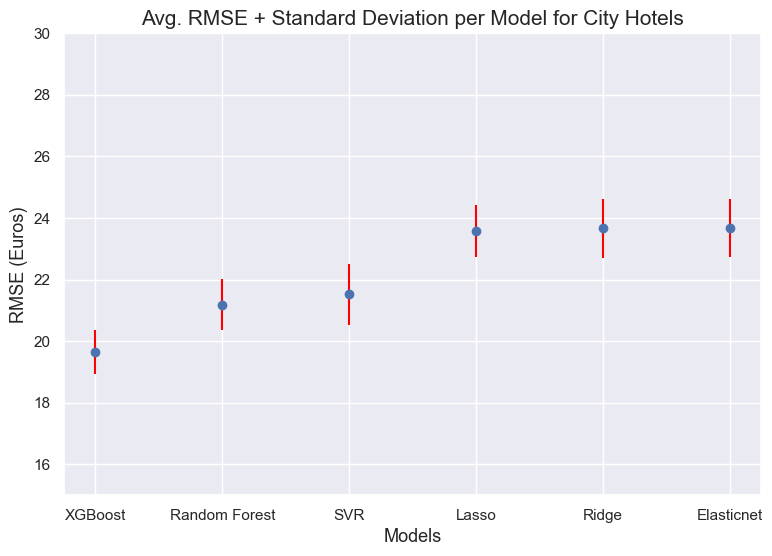

In [322]:
#plotting RMSE mean + stnd dev for City Hotel

plt.figure(figsize=(9,6))
plt.errorbar(x = c_scores['Model'], y = c_scores['Avg. Test RMSE'], yerr = c_scores['Stnd Dev.'],ecolor = 'red', fmt = 'o')
#plt.grid()
plt.xlabel('Models', size = 13)
plt.ylabel('RMSE (Euros)', size = 13)
plt.title('Avg. RMSE + Standard Deviation per Model for City Hotels', size = 15)
plt.ylim(15,30)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/Avg. Test RMSE for City Hotels.png', dpi = 300)
plt.show()

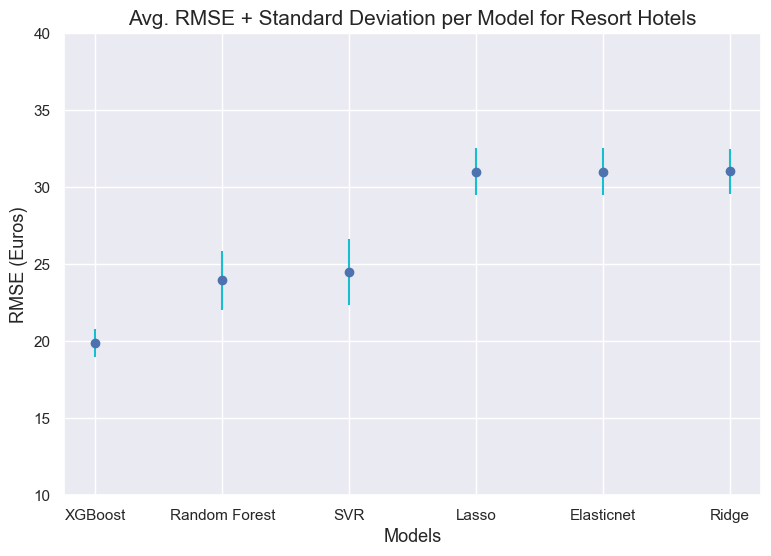

In [323]:
#plotting RMSE mean + stnd dev for Resort Hotel
plt.figure(figsize=(9,6))
plt.errorbar(x = r_scores['Model'], y = r_scores['Avg. Test RMSE'], yerr = r_scores['Stnd Dev.'],ecolor = '#17becf', fmt = 'o')
#plt.grid()
plt.xlabel('Models', size = 13)
plt.ylabel('RMSE (Euros)', size = 13)
plt.title('Avg. RMSE + Standard Deviation per Model for Resort Hotels', size = 15)
plt.ylim(10,40)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/Avg. Test RMSE for Resort Hotels.png', dpi = 300)
plt.show()

<a id = 'testvsbase'><a/>

###  *7.2  &ensp; General Performance of Baseline vs Test*

In [324]:
#all models used 
models = ['Lasso','Ridge','Elasticnet', 'SVR', 'Random Forest', 'XGBoost']

#list of test scores for each model for resort and city hotels
c_perf_model= [c_lasso_test_scores, c_ridge_test_scores, c_EL_test_scores, c_svr_test_scores, c_rf_test_scores, c_xgb_test_scores]
r_perf_model= [r_lasso_test_scores, r_ridge_test_scores, r_EL_test_scores, r_svr_test_scores, r_rf_test_scores, r_xgb_test_scores]

#list of baseline scores for each model
c_base_score = [c_lasso_baseline_scores, c_ridge_baseline_scores, c_EL_baseline_scores, c_svr_baseline_scores, c_rf_baseline_scores,c_xgb_baseline_scores]
r_base_score = [r_lasso_baseline_scores, r_ridge_baseline_scores, r_EL_baseline_scores, r_svr_baseline_scores, r_rf_baseline_scores,r_xgb_baseline_scores]





#put baseline scores/standard deviation into a dataframe with corresponding model

#finding average baseline scores
c_base_avg = [np.mean(score) for score in c_base_score]
r_base_avg= [np.mean(score) for score in r_base_score]

#finding standard deviations
c_stnddev_scores = [np.std(score) for score in c_base_score]
r_stnddev_scores = [np.std(score) for score in r_base_score]

#finding average test scores
c_test_avg = [np.mean(score) for score in c_perf_model]
r_test_avg = [np.mean(score) for score in r_perf_model]

#finding standard deviations from baseline for test scores

std_base_to_test_c = [(c_test_avg[i]-c_base_avg[i])/c_stnddev_scores[i]  for i in range(len(c_test_avg))]
std_base_to_test_r = [(r_test_avg[i]-r_base_avg[i])/r_stnddev_scores[i]  for i in range(len(r_test_avg))]






#putting all information into dataframe

c_baseline_scores = pd.DataFrame(zip(models,c_base_avg,c_stnddev_scores,c_test_avg,std_base_to_test_c), columns = ['Model','Avg. Baseline RMSE', 'Baseline Stnd Dev.', "Avg. Test RMSE", "Std. Dev. away from Baseline"]).sort_values(by = 'Avg. Test RMSE').reset_index(drop = True)
r_baseline_scores = pd.DataFrame(zip(models,r_base_avg,r_stnddev_scores,r_test_avg,std_base_to_test_r), columns = ['Model','Avg. Baseline RMSE', 'Baseline Stnd Dev.', "Avg. Test RMSE", "Std. Dev. away from Baseline"]).sort_values(by = 'Avg. Test RMSE').reset_index(drop = True)
display('City Hotel')
display(c_baseline_scores)
print('\n')
display('Resort Hotels')
display(r_baseline_scores)

'City Hotel'

Model  Avg. Baseline RMSE  Baseline Stnd Dev.  Avg. Test RMSE  \
0        XGBoost           41.721958            1.086489       19.637920   
1  Random Forest           41.434700            0.974120       21.191477   
2            SVR           41.434700            0.974120       21.532314   
3          Lasso           41.434700            0.974120       23.572096   
4          Ridge           41.434700            0.974120       23.664490   
5     Elasticnet           41.434700            0.974120       23.671337   

   Std. Dev. away from Baseline  
0                    -20.326054  
1                    -20.781028  
2                    -20.431136  
3                    -18.337163  
4                    -18.242314  
5                    -18.235285

'Resort Hotels'

Model  Avg. Baseline RMSE  Baseline Stnd Dev.  Avg. Test RMSE  \
0        XGBoost           64.415226            1.430470       19.874202   
1  Random Forest           64.317920            1.402861       23.963223   
2            SVR           64.317920            1.402861       24.498584   
3          Lasso           64.317920            1.402861       31.004636   
4     Elasticnet           64.317920            1.402861       31.004636   
5          Ridge           64.317920            1.402861       31.029670   

   Std. Dev. away from Baseline  
0                    -31.137337  
1                    -28.766006  
2                    -28.384385  
3                    -23.746681  
4                    -23.746681  
5                    -23.728836

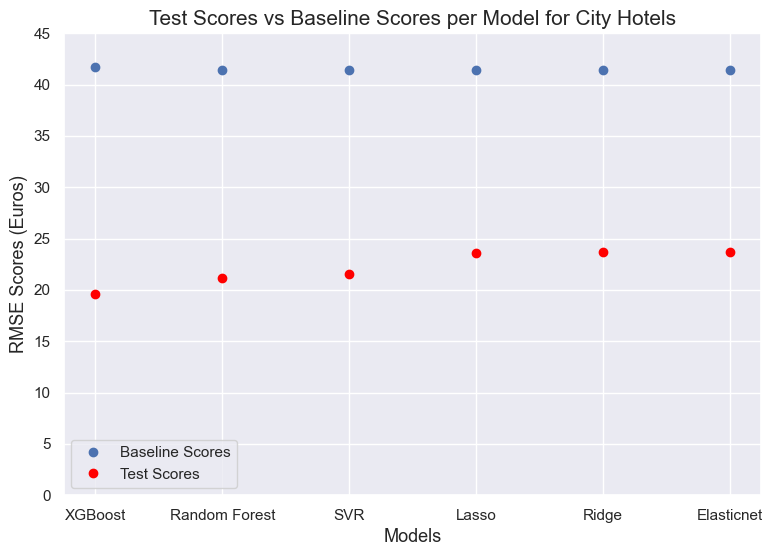

In [325]:
#plotting the baseline and test scores
plt.figure(figsize=(9,6))
plt.errorbar(x = 'Model',y = 'Avg. Baseline RMSE', data = c_baseline_scores, fmt = 'o', label = 'Baseline Scores')
plt.errorbar(x = 'Model',y = 'Avg. Test RMSE', data = c_baseline_scores, fmt = 'o', label = 'Test Scores', color = 'red')
plt.title("Test Scores vs Baseline Scores per Model for City Hotels", size = 15)
plt.xlabel('Models', size = 13)
plt.ylabel('RMSE Scores (Euros)', size = 13)
plt.ylim(0,45)
plt.legend()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/Avg. Test vs Baseline for City Hotel.png', dpi = 300)
plt.show()

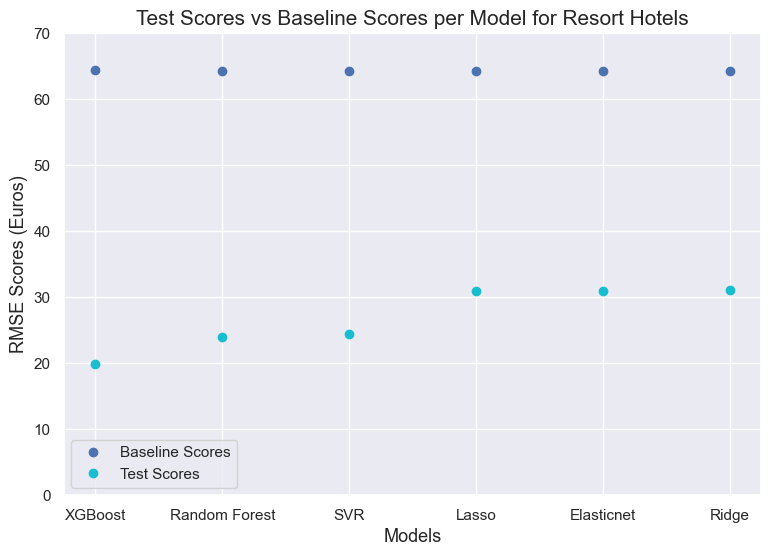

In [326]:
#plotting the baseline and test scores
plt.figure(figsize=(9,6))
plt.errorbar(x = 'Model',y = 'Avg. Baseline RMSE', data = r_baseline_scores, fmt = 'o', label = 'Baseline Scores')
plt.errorbar(x = 'Model',y = 'Avg. Test RMSE', data = r_baseline_scores, fmt = 'o', label = 'Test Scores',color = '#17becf')
plt.title("Test Scores vs Baseline Scores per Model for Resort Hotels", size = 15)
plt.xlabel('Models', size = 13)
plt.ylabel('RMSE Scores (Euros)', size = 13)
plt.ylim(0,70)
plt.legend()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/Avg. Test vs Baseline for Resort Hotel.png', dpi = 300)
plt.show()

<a id = 'global'><a/>

###  *7.3  &ensp; Global Importance Metrics*

In [327]:
#using best xgb model for permutation importance and xgb

#city hotel
c_xgb_best = c_xgb_best_models[np.argmin(c_xgb_test_scores)]


#finding corresponding tests sets
c_xgb_best_X = c_test_sets[np.argmin(c_xgb_test_scores)][0]
c_xgb_best_y = c_test_sets[np.argmin(c_xgb_test_scores)][1]

#finding corresponding train set

c_xgb_train_X = c_train_sets[np.argmin(c_xgb_test_scores)]


#resort hotel
r_xgb_best = r_xgb_best_models[np.argmin(r_xgb_test_scores)]


#finding corresponding tests sets
r_xgb_best_X = r_test_sets[np.argmin(r_xgb_test_scores)][0]
r_xgb_best_y = r_test_sets[np.argmin(r_xgb_test_scores)][1]

#finding corresponding train set

r_xgb_train_X = r_train_sets[np.argmin(r_xgb_test_scores)]

> #### 7.3.1 &ensp; Permutation Importance

In [328]:
#City Hotel

#fit preprocessor
preprocessor_xgb.fit(c_xgb_train_X) # we don't need to save

c_xgb_best_X_prep = preprocessor_xgb.transform(c_xgb_best_X)

true_rmse= mean_squared_error(c_xgb_best_y, c_xgb_best.predict(c_xgb_best_X_prep),squared = False)
print("True RMSE:", true_rmse)

#collecting features names
ftrs = c_xgb_train_X.columns

# num of runs per each feature
nr_runs = 5

#set a seed
np.random.seed(13)

# Array of scores per each feature
scores = np.zeros([len(ftrs),nr_runs])



# Iterate through each predictor
for i in range(len(ftrs)):
    rmse_scores = []
    #running 5 times per feature
    for j in range(nr_runs):
        #creating shallow copy of X_test
        X_test_shuffled = c_xgb_best_X.copy()
        #shuffling values for a particular feature
        X_test_shuffled[ftrs[i]] = np.random.permutation(c_xgb_best_X[ftrs[i]].values)
        #preprocessing new X_test by transforming using fitted preprocessor
        X_test_shuffled_prep = preprocessor_xgb.transform(X_test_shuffled)
        #calculate new RMSE with perturbed feature
        new_rmse = mean_squared_error( c_xgb_best_y,c_xgb_best.predict(X_test_shuffled_prep),\
                                      squared = False)
        #append difference in RMSE scores
        rmse_scores.append(new_rmse)
    #calculate mean of scores and append to scores array
    scores[i] = rmse_scores



True RMSE: 18.66481016589709


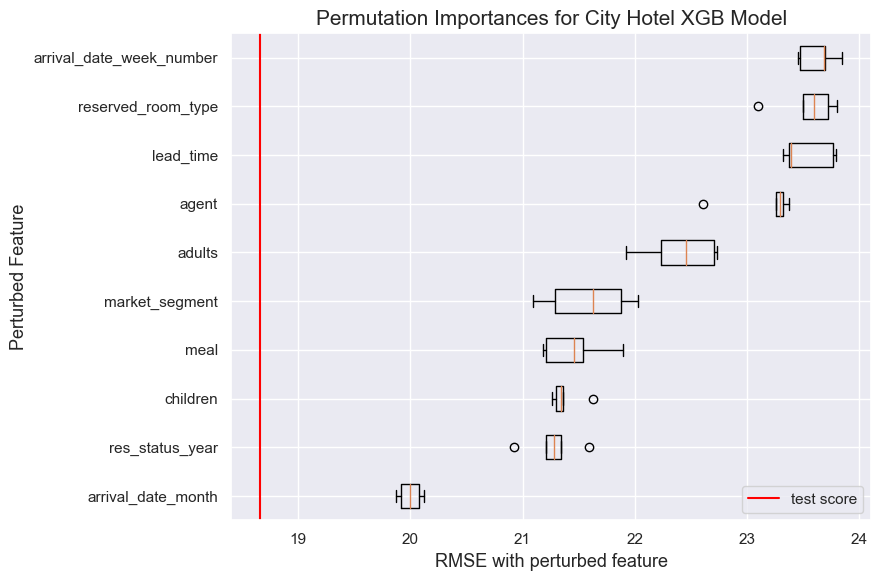

In [329]:
plt.figure(figsize=(9,6))
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1] #[::-1] reverse the order fo the list
plt.rcParams.update({'font.size': 13})

plt.boxplot(scores[sorted_indcs[:10]][::-1].T,labels=ftrs[sorted_indcs[:10]][::-1], vert=False)#needed todo [::-1] because overall qual was on the bottom
plt.axvline(true_rmse,label='test score', color = 'red')
plt.title("Permutation Importances for City Hotel XGB Model", size = 15)
plt.xlabel('RMSE with perturbed feature', size = 13)
plt.ylabel("Perturbed Feature", size = 13)
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/Permutation Importance for City Hotel.png', dpi = 300)
plt.show()

In [165]:
#City Hotel

#fit preprocessor
preprocessor_xgb.fit(r_xgb_train_X) # we don't need to save

r_xgb_best_X_prep = preprocessor_xgb.transform(r_xgb_best_X)

true_rmse= mean_squared_error(r_xgb_best_y, r_xgb_best.predict(r_xgb_best_X_prep),squared = False)
print("True RMSE:", true_rmse)

#collecting features names
ftrs = r_xgb_train_X.columns

# num of runs per each feature
nr_runs = 5

#set a seed
np.random.seed(13)

# Array of scores per each feature
scores = np.zeros([len(ftrs),nr_runs])



# Iterate through each predictor
for i in range(len(ftrs)):
    rmse_scores = []
    #running 5 times per feature
    for j in range(nr_runs):
        #creating shallow copy of X_test
        X_test_shuffled = r_xgb_best_X.copy()
        #shuffling values for a particular feature
        X_test_shuffled[ftrs[i]] = np.random.permutation(r_xgb_best_X[ftrs[i]].values)
        #preprocessing new X_test by transforming using fitted preprocessor
        X_test_shuffled_prep = preprocessor_xgb.transform(X_test_shuffled)
        #calculate new RMSE with perturbed feature
        new_rmse = mean_squared_error(r_xgb_best_y,r_xgb_best.predict(X_test_shuffled_prep),\
                                      squared = False)
        #append difference in RMSE scores
        rmse_scores.append(new_rmse)
    #calculate mean of scores and append to scores array
    scores[i] = rmse_scores



True RMSE: 18.6384353988286


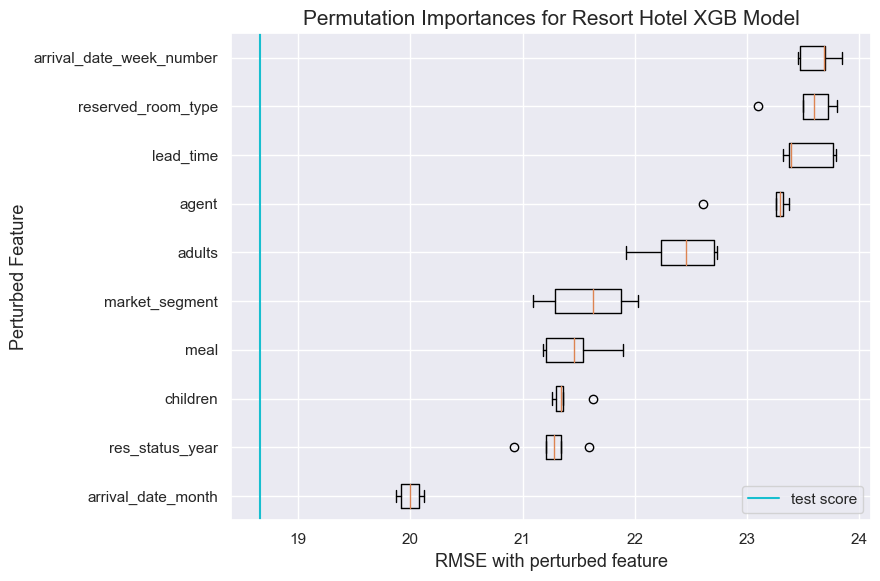

In [330]:
plt.figure(figsize=(9,6))
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1] #[::-1] reverse the order fo the list
plt.rcParams.update({'font.size': 13})

plt.boxplot(scores[sorted_indcs[:10]][::-1].T,labels=ftrs[sorted_indcs[:10]][::-1], vert=False)#needed todo [::-1] because overall qual was on the bottom
plt.axvline(true_rmse,label='test score', color = '#17becf')
plt.title("Permutation Importances for Resort Hotel XGB Model", size = 15)
plt.xlabel('RMSE with perturbed feature', size =13)
plt.ylabel("Perturbed Feature", size =13)
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/Permutation Importance for Resort Hotel.png', dpi = 300)
plt.show()


> #### 7.3.2 &ensp; XGB Gain

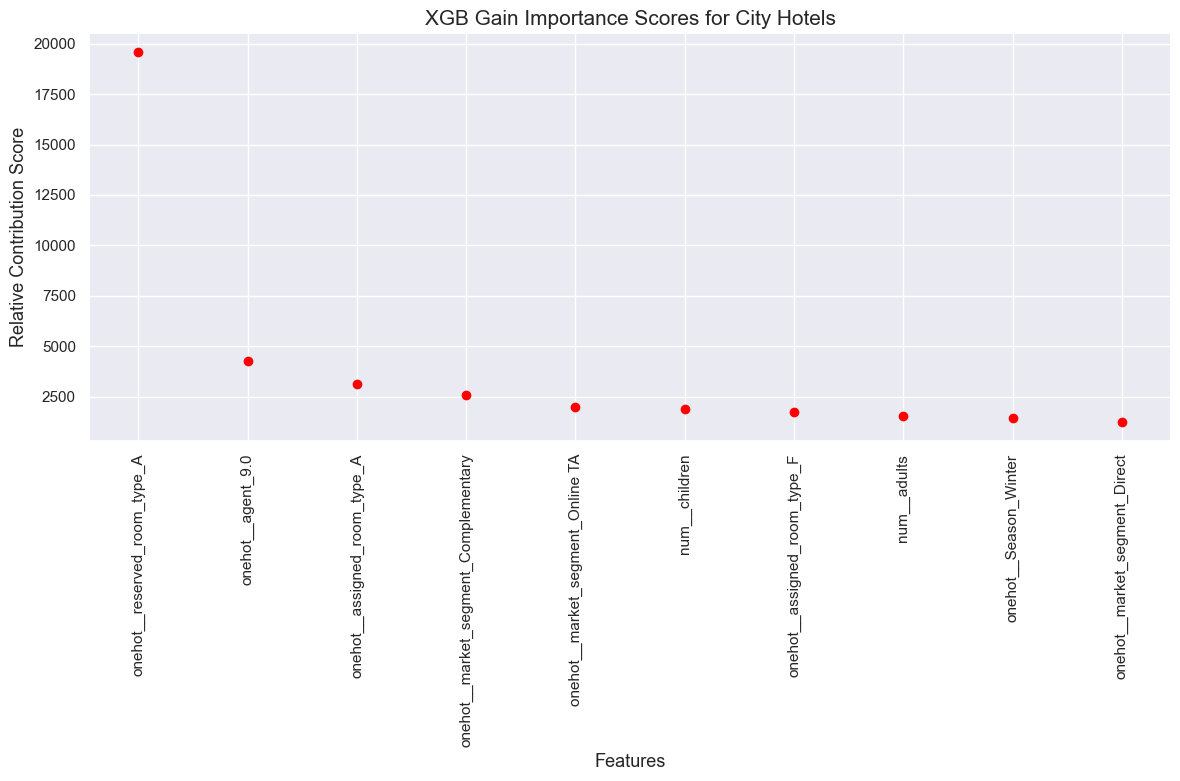

In [331]:
#City Hotel


#plotting 10 most important features based on XGB Gain
feature_important = c_xgb_best.get_booster().get_score(importance_type= 'gain')
keys = list(feature_important.keys())
score_df = pd.DataFrame(list(feature_important.items()),columns = ('Feature','Score'))
score_df = score_df.sort_values(by = 'Score',ascending = False).reset_index(\
                                                inplace = False, drop = True)
top_10 = score_df.iloc[:10,:]


#setting plot size
plt.figure(figsize=(12,8))
plt.errorbar(x = top_10['Feature'], y = top_10['Score'], color = 'red', fmt = 'o')
#plt.semilogy()
#plt.grid()
plt.xlabel('Features',size = 13)
plt.ylabel("Relative Contribution Score", size = 13)
plt.title("XGB Gain Importance Scores for City Hotels", size = 15)
plt.xticks (rotation = 90) 
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/XGB Gain for City Hotel.png', dpi = 300)
plt.show()

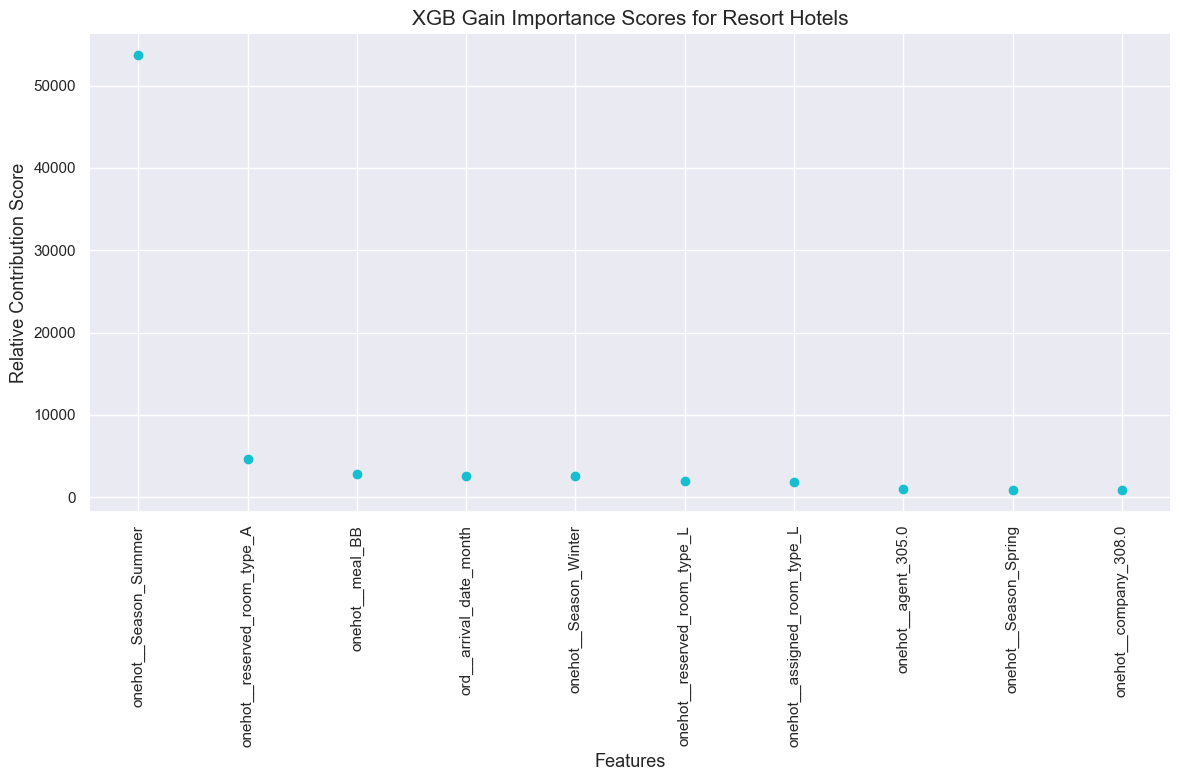

In [332]:
#City Hotel


#plotting 10 most important features based on XGB Gain
feature_important = r_xgb_best.get_booster().get_score(importance_type= 'gain')
keys = list(feature_important.keys())
score_df = pd.DataFrame(list(feature_important.items()),columns = ('Feature','Score'))
score_df = score_df.sort_values(by = 'Score',ascending = False).reset_index(\
                                                inplace = False, drop = True)
top_10 = score_df.iloc[:10,:]


#setting plot size
plt.figure(figsize=(12,8))
plt.errorbar(x = top_10['Feature'], y = top_10['Score'],color = '#17becf', fmt = 'o')
#plt.semilogy()
#plt.grid()
plt.xlabel('Features',size = 13)
plt.ylabel("Relative Contribution Score", size = 13)
plt.title("XGB Gain Importance Scores for Resort Hotels", size = 15)
plt.xticks (rotation = 90) 
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/XGB Gain for Resort Hotel.png', dpi = 300)
plt.show()

> #### 7.3.2 &ensp; Shap Value (Global)

In [119]:
import shap
shap.initjs() # required for visualizations later on

C:\Users\stuar\anaconda3\envs\data1030\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [185]:
#rewriting variables for shap global due to error i was recieving

#city hotel

#best model
city_bestMod_xgb = c_xgb_best_models[np.argmin(c_xgb_test_scores)]


#finding corresponding tests sets
city_xgb_testset_X = c_test_sets[np.argmin(c_xgb_test_scores)][0]
city_xgb_testset_y = c_test_sets[np.argmin(c_xgb_test_scores)][1]

#finding corresponding train set

city_xgb_trainset_X = c_train_sets[np.argmin(c_xgb_test_scores)]




#resort hotel

#best model
resort_bestMod_xgb = r_xgb_best_models[np.argmin(r_xgb_test_scores)]


#finding corresponding tests sets
resort_xgb_testset_X = r_test_sets[np.argmin(r_xgb_test_scores)][0]
resort_xgb_testset_y = r_test_sets[np.argmin(r_xgb_test_scores)][1]

#finding corresponding train set

resort_xgb_trainset_X = r_train_sets[np.argmin(r_xgb_test_scores)]

In [333]:
#City Hotel Global
import shap
shap.initjs()

#fit preprocessor
df_train_X_c = preprocessor_xgb.fit_transform(city_xgb_trainset_X) # we don't need to save

#defining features names
feature_names = preprocessor_xgb.get_feature_names_out()

#transforming test set
df_test_X_c = preprocessor_xgb.transform(city_xgb_testset_X)

#turning preprocessed X test into data frame
df_test_X_c = pd.DataFrame(data=df_test_X_c ,columns = feature_names)

#use XGB to calculate shap values
explainer_c = shap.Explainer(city_bestMod_xgb, df_train_X_c) #or TreeExplainer: either one works
shap_values_c = explainer_c.shap_values(df_test_X_c)

100%|===================| 996/1000 [01:42<00:00]        

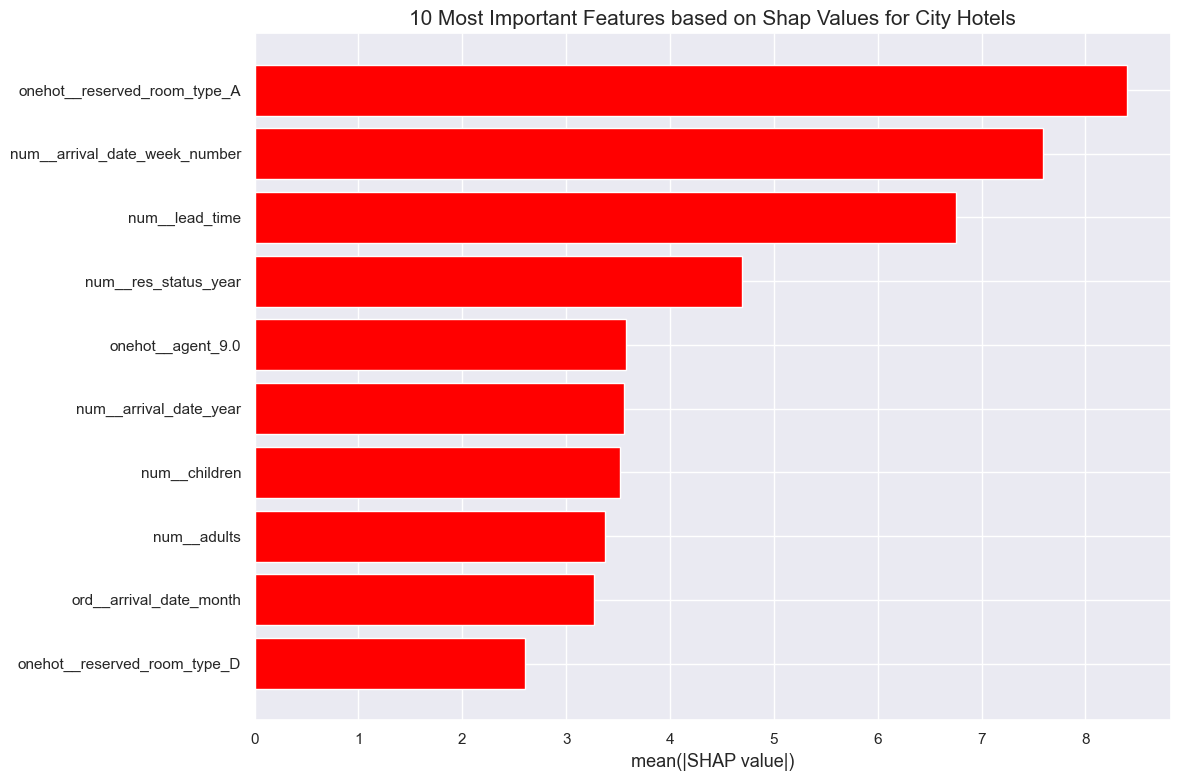

In [334]:

#saving shap values in a dataframe
shap_df_c = pd.DataFrame(shap_values_c, columns = df_test_X_c.columns)
shap_df_c.head()

#calculating global importance
global_imp = np.mean(np.abs(shap_df_c),axis=0) 
#saving results in df
indcs = np.argsort(global_imp) # will order index order from least to greatest

#creating feature names

feature_names = df_test_X_c.columns

#plot 10 highest global importance shap values
plt.figure(figsize=(12,8))
plt.barh(feature_names[indcs[-10:]],global_imp[indcs[-10:]],color = 'red')
plt.xlabel('mean(|SHAP value|)', size = 13)
plt.title('10 Most Important Features based on Shap Values for City Hotels', size = 15)
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/SHAP Global for City Hotel.png', dpi = 300)
plt.show()

In [336]:
#Resort Hotel Global

#fit preprocessor
df_train_X_r = preprocessor_xgb.fit_transform(resort_xgb_trainset_X) # we don't need to save

#defining features names
feature_names = preprocessor_xgb.get_feature_names_out()

#transforming test set
df_test_X_r = preprocessor_xgb.transform(resort_xgb_testset_X)

#turning preprocessed X test into data frame
df_test_X_r = pd.DataFrame(data=df_test_X_r ,columns = feature_names)

#use XGB to calculate shap values
explainer_r = shap.Explainer(resort_bestMod_xgb, df_train_X_r) #or TreeExplainer: either one works
shap_values_r = explainer_r.shap_values(df_test_X_r)

100%|===================| 1197/1200 [06:18<00:00]        

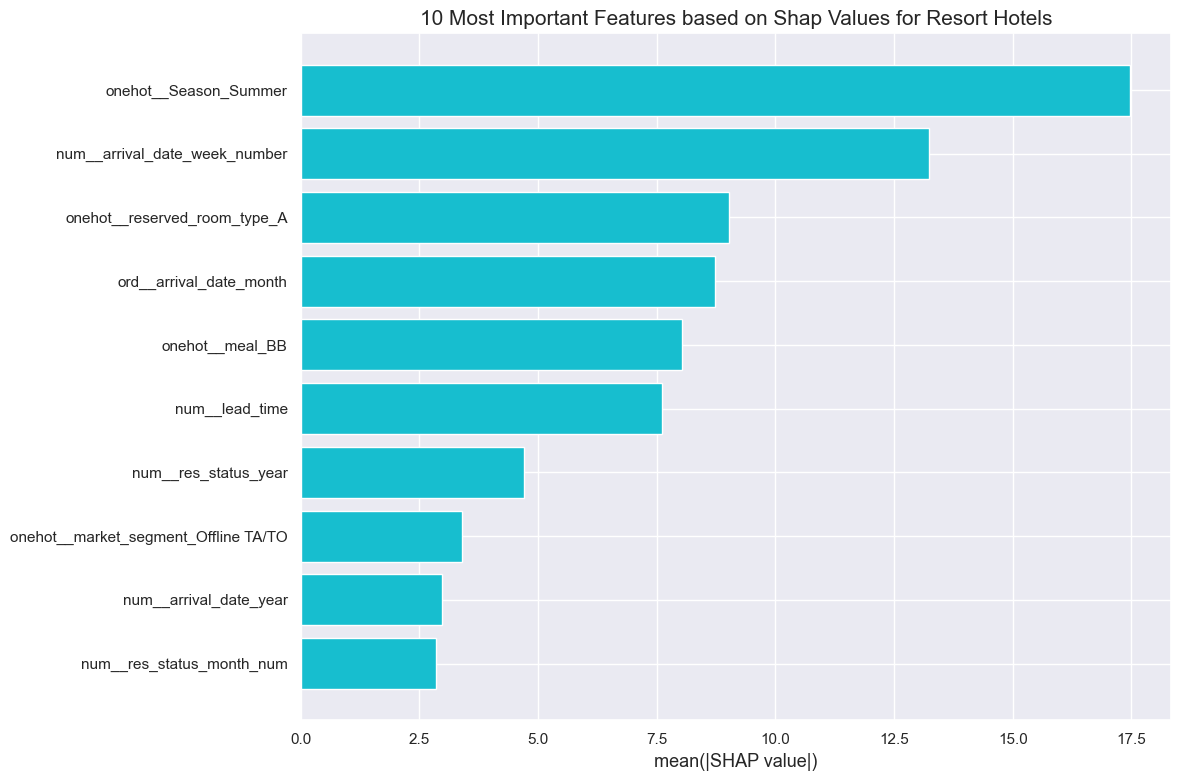

In [337]:

#saving shap values in a dataframe
shap_df_r = pd.DataFrame(shap_values_r, columns = df_test_X_r.columns)
shap_df_r.head()

#calculating global importance
global_imp = np.mean(np.abs(shap_df_r),axis=0) 
#saving results in df
indcs = np.argsort(global_imp) # will order index order from least to greatest

#creating feature names

feature_names = df_test_X_r.columns

#plot 10 highest global importance shap values
plt.figure(figsize=(12,8))
plt.barh(feature_names[indcs[-10:]],global_imp[indcs[-10:]],color = '#17becf')
plt.xlabel('mean(|SHAP value|)', size = 13)
plt.title('10 Most Important Features based on Shap Values for Resort Hotels', size = 15)
plt.tight_layout()
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/Predicting_Hotel_Financial_Health/results/SHAP Global for Resort Hotel.png', dpi = 300)
plt.show()

###  *7.4  &ensp; Local Importance Metrics (Shap Values)*

> #### 7.4.1 &ensp; City Hotels

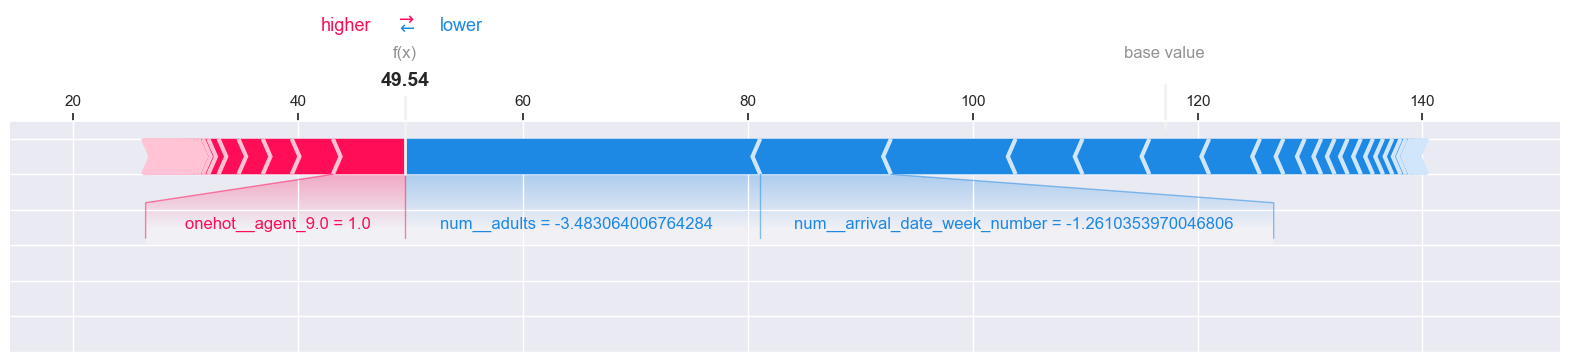

<Figure size 800x500 with 0 Axes>

In [257]:
#index 0
shap.force_plot(explainer_c.expected_value, shap_values_c[0], features = df_test_X_c.iloc[0,:],feature_names = df_test_X_c.columns, matplotlib = True)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/\
Predicting_Hotel_Financial_Health/results/SHAP Value Local Index 0.png', dpi = 300)


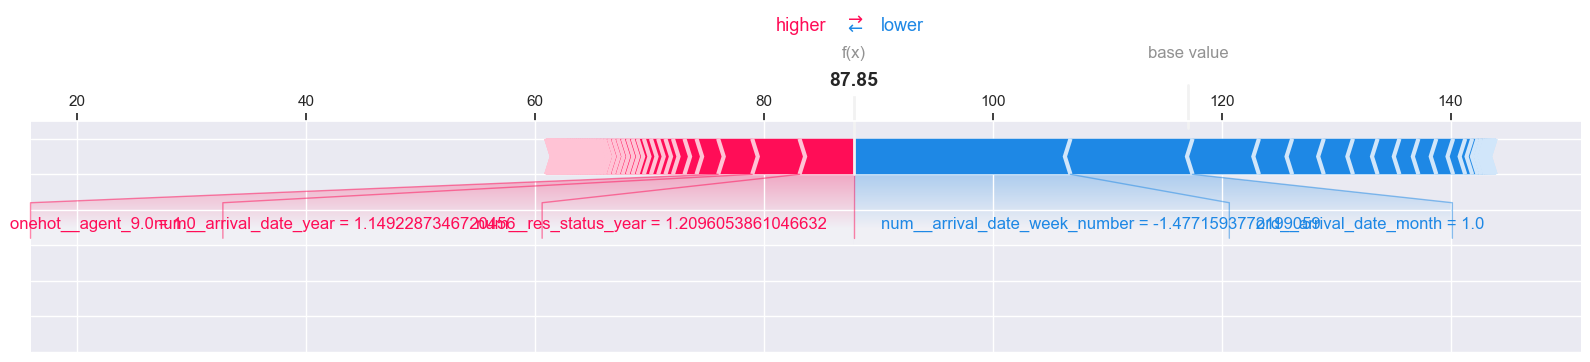

<Figure size 800x500 with 0 Axes>

In [251]:
#index 100
shap.force_plot(explainer_c.expected_value, shap_values_c[100], features = df_test_X_c.iloc[100,:],feature_names = df_test_X_c.columns, matplotlib = True)


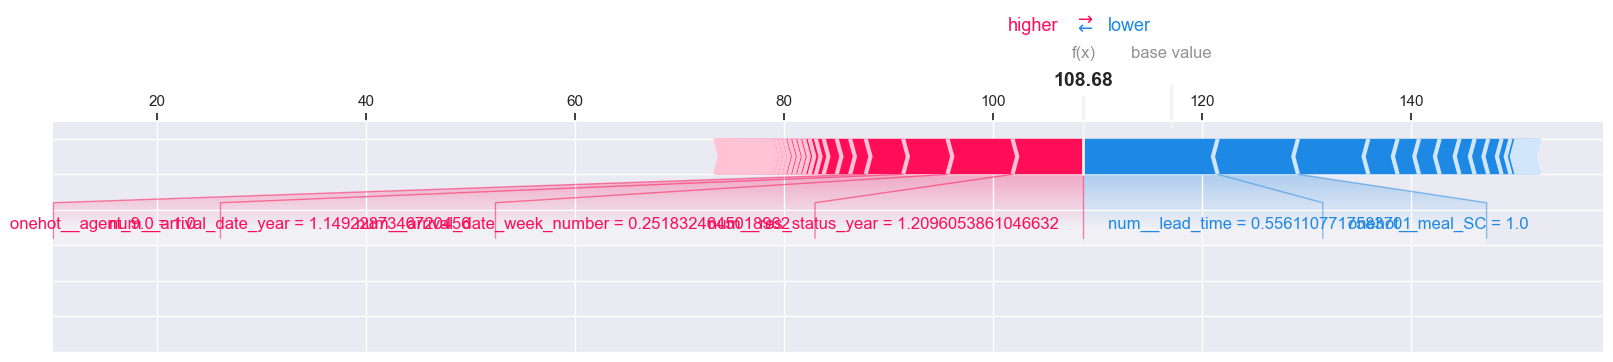

<Figure size 800x500 with 0 Axes>

In [252]:
#index 200
shap.force_plot(explainer_c.expected_value, shap_values_c[200], features = df_test_X_c.iloc[200,:],feature_names = df_test_X_c.columns, matplotlib = True)


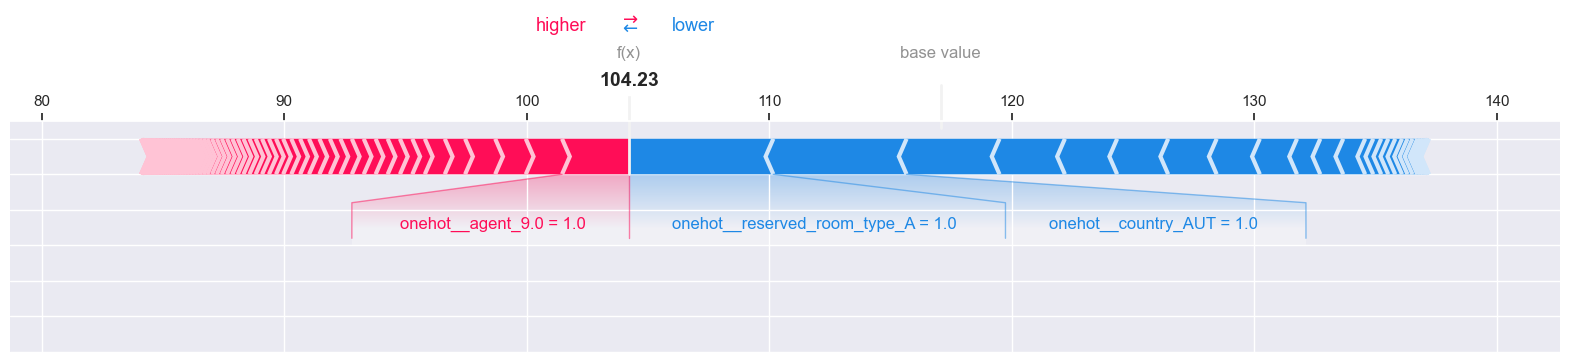

<Figure size 800x500 with 0 Axes>

In [254]:
#index 300
shap.force_plot(explainer_c.expected_value, shap_values_c[300], features = df_test_X_c.iloc[300,:],feature_names = df_test_X_c.columns, matplotlib = True)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/\
Predicting_Hotel_Financial_Health/results/SHAP Value Local Index 300.png', dpi = 300)
plt.show()

In [204]:
#index 400
shap.force_plot(explainer_c.expected_value, shap_values_c[400], features = df_test_X_c.iloc[400,:],feature_names = df_test_X_c.columns, matplotlib = True)


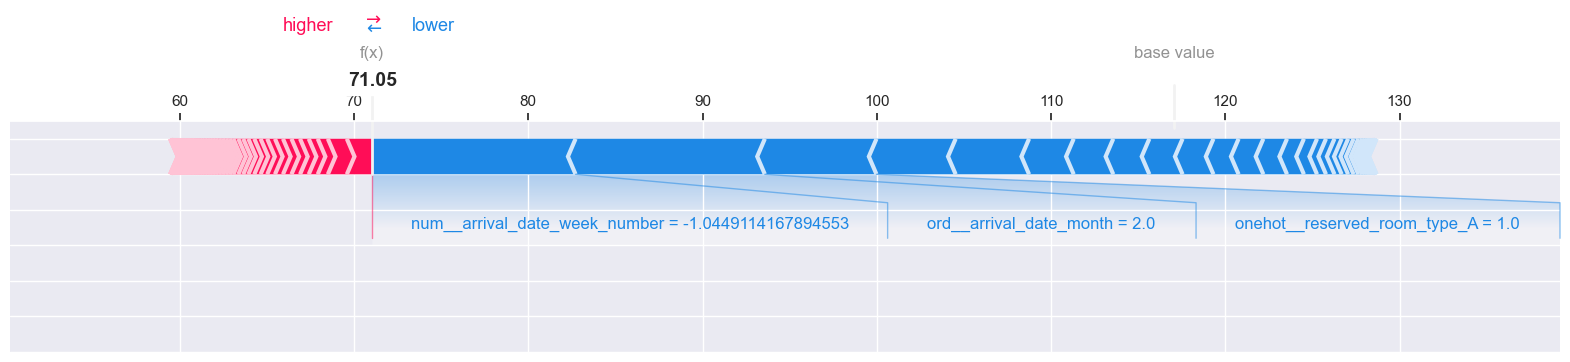

<Figure size 800x500 with 0 Axes>

In [255]:
#index 800
shap.force_plot(explainer_c.expected_value, shap_values_c[800], features = df_test_X_c.iloc[800,:],feature_names = df_test_X_c.columns, matplotlib = True)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/\
Predicting_Hotel_Financial_Health/results/SHAP Value Local Index 800.png', dpi = 300)
plt.show()

> #### 7.4.2 &ensp; Resort Hotels

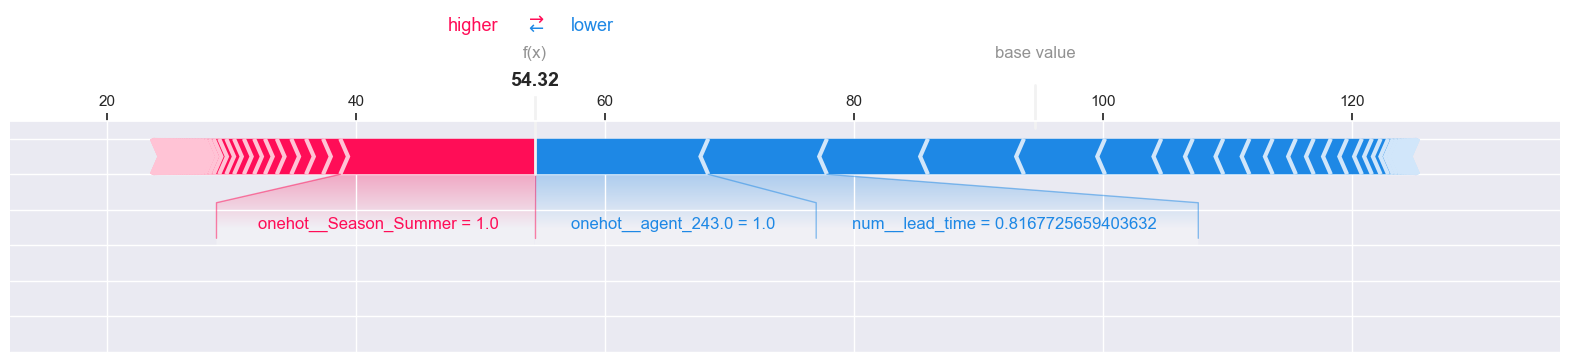

<Figure size 800x500 with 0 Axes>

In [256]:
#index 0
shap.force_plot(explainer_r.expected_value, shap_values_r[0], features = df_test_X_r.iloc[0,:],feature_names = df_test_X_r.columns, matplotlib = True)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/\
Predicting_Hotel_Financial_Health/results/SHAP Value Local Index 100.png', dpi = 300)
plt.show()

In [209]:
#index 100
shap.force_plot(explainer_r.expected_value, shap_values_r[100], features = df_test_X_r.iloc[100,:],feature_names = df_test_X_r.columns, matplotlib = True)
plt.savefig('C:/Users/stuar/OneDrive/Documents/Python Scripts/Brown Data Science/DATA1030-Fall2022/Project/\
Predicting_Hotel_Financial_Health/results/SHAP Value Local Index 100.png', dpi = 300)
plt.show()

In [210]:
#index 200
shap.force_plot(explainer_r.expected_value, shap_values_r[200], features = df_test_X_r.iloc[200,:],feature_names = df_test_X_r.columns)

In [211]:
#index 300
shap.force_plot(explainer_r.expected_value, shap_values_r[300], features = df_test_X_r.iloc[300,:],feature_names = df_test_X_r.columns)

In [212]:
#index 400
shap.force_plot(explainer_r.expected_value, shap_values_r[400], features = df_test_X_r.iloc[400,:],feature_names = df_test_X_r.columns)

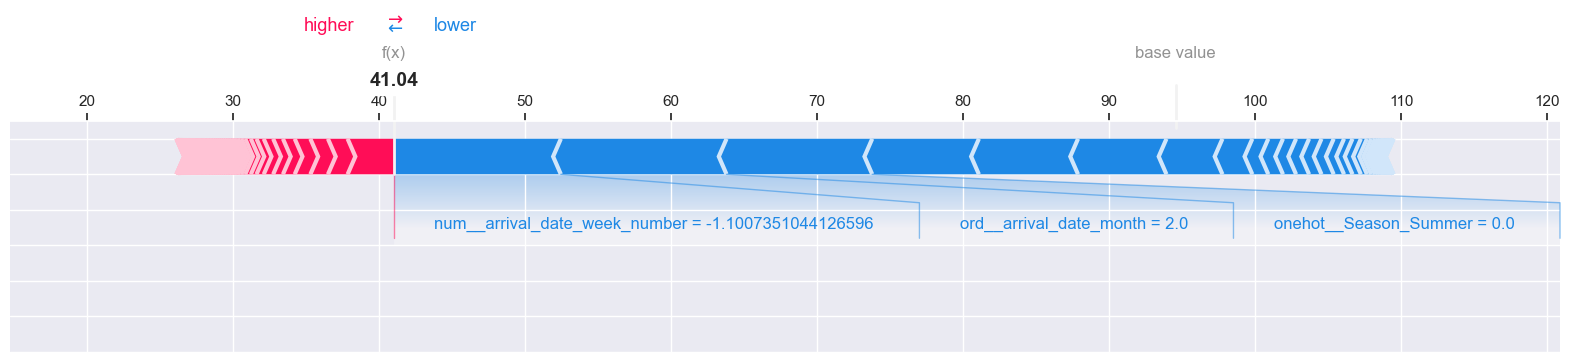

In [258]:
#index 800
shap.force_plot(explainer_r.expected_value, shap_values_r[800], features = df_test_X_r.iloc[800,:],feature_names = df_test_X_r.columns, matplotlib = True
               )